# USA Resiliece Opportunity Mapping Data Processing

The data that we have selected for the platform can be seen [here](https://docs.google.com/spreadsheets/d/1O1L8mv3_zg5507bO0j4Cba0Yiz3rKErNhfIwG8yFFpE/edit?usp=sharing). 

## Table of Contents
- ## [Python libraries](#libraries)
- ## [Utils](#utils)
- ## [List of datasets and indicators](#datasets)
- ## [Read vector data](#vector_data)
    - **[Sates](#states)**
    - **[County](#county)**  
    - **[Census tract](#tract)**
- ## [Preprocess data](#preprocess)
    - ### 1. [Carto data](#carto_data)
    - ### 2. [Wildfire data](#wildfire_data)
    - ### 3. [GEE data](#gee_data)
    - ### 4. [CDC Social Vulnerability Index data](#cdc_data)
- ## [Merge all datasets](#merge_data)

<a id='libraries'></a>
## Python libraries

In [3]:
from matplotlib import pyplot as plt
import LMIPy as lmi
import geopandas as gpd
import shapely.wkt
import pandas as pd
import requests
import zipfile
import json
import io
import os

<a id='utils'></a>
## Utils

In [4]:
#import functions form notebook
%run './preprocessing_main_functions.ipynb'

<a id='datasets'></a>
## List of datasets and indicators
**Datasets**

In [3]:
datasets = {
    'gee':{
        'extreme_heat_days':'4077d297-c3d4-4302-8e2b-2a1701a24d8d',
        'extreme_precipitation_days':'6a818d38-2361-4c9a-bd9e-c0cd3493d5ce',
        'landslide_susceptibility':'ea2db3a6-49c8-4d41-a2ab-758eb6fe4bc0',
        'earthquake_frequency_and_distribution':'b3ebc10d-9de8-4ee6-870d-1d049e8e2a99',
        'volcano_frequency_and_distribution':'74ebf4fe-6afb-46aa-a820-96fcae9a7e03',
    },
    'carto':{
        'riverine_flood_risk':'5152c286-53c1-4583-9519-816a6e41889d',
        'costal_flood_risk':'5152c286-53c1-4583-9519-816a6e41889d',
        'drought_risk':'5152c286-53c1-4583-9519-816a6e41889d',
    },
    'others':{
        'Wildfires': 'https://www.nature.com/articles/s41597-019-0312-2',
        'CDC Social Vulnerability Index':'https://svi.cdc.gov/Documents/Data/2018_SVI_Data/SVI2018Documentation-508.pdf',
    }
}

datasets = pd.DataFrame(datasets)
datasets

,gee,carto,others
extreme_heat_days,4077d297-c3d4-4302-8e2b-2a1701a24d8d,NaN,NaN
extreme_precipitation_days,6a818d38-2361-4c9a-bd9e-c0cd3493d5ce,NaN,NaN
landslide_susceptibility,ea2db3a6-49c8-4d41-a2ab-758eb6fe4bc0,NaN,NaN
earthquake_frequency_and_distribution,b3ebc10d-9de8-4ee6-870d-1d049e8e2a99,NaN,NaN
volcano_frequency_and_distribution,74ebf4fe-6afb-46aa-a820-96fcae9a7e03,NaN,NaN
riverine_flood_risk,NaN,5152c286-53c1-4583-9519-816a6e41889d,NaN
costal_flood_risk,NaN,5152c286-53c1-4583-9519-816a6e41889d,NaN
drought_risk,NaN,5152c286-53c1-4583-9519-816a6e41889d,NaN
Wildfires,NaN,NaN,https://www.nature.com/articles/s41597-019-0312-2
CDC Social Vulnerability Index,NaN,NaN,https://svi.cdc.gov/Documents/Data/2018_SVI_Da...


**Indicators**

In [4]:
indicators = {'Name':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
              'household composition & disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian with a disability', 'percentage of single parent households with children under 18',
             'minority status & language', 'minority (all persons except white, non-Hispanic)', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'Slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt'],
 'Category': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'Group': list(range(0, 9)) + [9, 9.1,9.2,9.3,9.4] + [10, 10.1,10.2,10.3,10.4]  + [11, 11.1,11.2] + [12, 12.1,12.2,12.3,12.4,12.5]}

indicators = pd.DataFrame(indicators)
#indicators.to_csv('../data/indicators_list.csv')
indicators

,Name,Slug,Category,Group
0,riverine flood risk,rfr,climate risk,0.0
1,coastal flood risk,cfr,climate risk,1.0
2,extreme heat days,ehd,climate risk,2.0
3,extreme precipitation days,epd,climate risk,3.0
4,drought risk,drr,climate risk,4.0
5,landslide susceptibility,lss,climate risk,5.0
6,earthquake frequency and distribution,efd,climate risk,6.0
7,volcano frequency and distribution,vfd,climate risk,7.0
8,wildfires,wlf,climate risk,8.0
9,socioeconomic status,ses,vulnerability,9.0


In [5]:
indicators = {'group': ['climate risk'] * 9 + ['vulnerability'] * 5,
 'indicator':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['population', 'community resilience estimate', 'unemployment', 'median household income', 'poverty'],
 'slug':['rfr', 'cfr', 'ehd', 'epd', 'drr', 'lss', 'efd','vfd', 'wlf'] + ['pop', 'cre', 'uep', 'mhi', 'pvt'],
 'state_labels':
     [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'], 
      '', 
      '',
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'], 
      ['Less than 30 kha', '30 kha to 280 kha', '280 kha to 1 Mha', '1 Mha to 3 Mha', 'More than 3 Mha'],
      ['Less than 1.5M', '1.5M to 3M', '3M to 6M', '6M to 9M', 'More than 9M'], 
      ['Less than 22.6%', '22.6% to 24.2%', '24.2% to 25.7%', '25.7% to 27.5%', '27.5% or higher'], 
      ['Less than 2.9%', '2.9% to 3.3%', '3.3% to 3.6%', '3.6% to 4.1%', '4.1% or higher'], 
      ['Less than $54k', '$54k to $58k', '$58k to $62k', '$62k to $73k', '$73k or higher'], 
      ['Less than 10.6%', '10.6% to 11.9%', '11.9% to 13.1%', '13.1% to 15.2%', '15.2% or higher']],
 'county_labels':
    [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'], 
      '', 
      '',
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'], 
      ['Less than 1 kha', '1 kha to 4 kha', '4 kha to 10 kha', '10 kha to 35 kha', 'More than 35 kha'],
      ['Less than 9k', '9k to 20k', '20k to 40k', '40k to 95k', 'More than 95k'], 
      ['Less than 21.5%', '21.5% to 24.3%', '24.3% to 26.9%', '26.9% to 30.0%', '30.0% or higher'], 
      ['Data not available', 'Less than 2.9%', '2.9% to 3.4%', '3.4% to 4.0%', '4.0% to 4.9%', '4.9% or higher'], 
      ['Data not available', 'Less than $42k', '$42k to $48k', '$48k to $53k', '$53k to $61k', '$61k or higher'], 
      ['Data not available', 'Less than 10.2%', '10.2% to 12.8%', '12.8% to 15.5%', '15.5% to 19.6%', '19.6% or higher']],
 'title':
    ['Riverine flood risk', 
      'Coastal flood risk', 
      'Extreme heat days', 
      'Extreme precipitation days',
      'Drought risk', 
      'Landslide susceptibility', 
      'Earthquake hazards - frequency (deciles)',
      'Volcano hazards - frequency (deciles)', 
      'Total hectares burned (2001-2017)',
      'Population', 
      'Percentage of residents with 3+ risk factors', 
      'Percentage of people in unemployment', 
      'Median household income', 
      'Percentage of people in poverty'],
 'description':
    ['Riverine flood risk measures the percentage of population expected to be affected by Riverine flooding in an average year, accounting for existing flood-protection standards. Flood risk is assessed using hazard (inundation caused by river overflow), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by Riverine floods on average.', 
      'Coastal flood risk measures the percentage of the population expected to be affected by coastal flooding in an average year, accounting for existing flood protection standards. Flood risk is assessed using hazard (inundation caused by storm surge), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by coastal floods on average.', 
      'Extreme heat days represent the annual average count of days with heat greater than the 99th percentile of the baseline, as derived from the Localized Constructed Analogs (LOCA). LOCA is a technique for downscaling climate model projections of the future climate. The method estimates finer-scale climate detail using the systematic historical effects of topography on local weather patterns. The LOCA downscaled climate projections provide temperature and precipitation on pixels that are six kilometers (3.7 miles) across. The data are daily, covering the period 1950-2100 for 32 global climate models. LOCA attempts to better preserve extreme hot days and heavy rain events than the previous generation of downscaling approaches. While previous downscaling techniques typically formed the downscaled model day using a weighted average of 30 similar historical days, LOCA looks locally around each point of interest to find the one best matching day. The data spans from Mexico through southern Canada and can be used to assess climate impacts across much of North America, including the entire conterminous U.S. The work represents a collaboration across many groups, including SIO, the California Energy Commission, the U.S. Army Corps of Engineers, the U.S. Geological Survey, the Bureau of Reclamation, the NOAA Regional Integrated Sciences and Assessments (RISA) program, the Climate Analytics Group, the nonprofit group Climate Central, Lawrence Livermore National Laboratory, NASA Ames Research Center, Santa Clara University, the Cooperative Institute for Research in Environmental Sciences at the University of Colorado Boulder, and the Southwest Climate Science Center.', 
      'Extreme precipitation days represent the annual average count of days with precipitation greater than the 99th percentile of the baseline, as derived from the Localized Constructed Analogs (LOCA). LOCA is a technique for downscaling climate model projections of the future climate. The method estimates finer-scale climate detail using the systematic historical effects of topography on local weather patterns. The LOCA downscaled climate projections provide temperature and precipitation on pixels that are six kilometers (3.7 miles) across. The data are daily, covering the period 1950-2100 for 32 global climate models. LOCA attempts to better preserve extreme hot days and heavy rain events than the previous generation of downscaling approaches. While previous downscaling techniques typically formed the downscaled model day using a weighted average of 30 similar historical days, LOCA looks locally around each point of interest to find the one best matching day. The data spans from Mexico through southern Canada and can be used to assess climate impacts across much of North America, including the entire conterminous U.S. The work represents a collaboration across many groups, including SIO, the California Energy Commission, the U.S. Army Corps of Engineers, the U.S. Geological Survey, the Bureau of Reclamation, the NOAA Regional Integrated Sciences and Assessments (RISA) program, the Climate Analytics Group, the nonprofit group Climate Central, Lawrence Livermore National Laboratory, NASA Ames Research Center, Santa Clara University, the Cooperative Institute for Research in Environmental Sciences at the University of Colorado Boulder, and the Southwest Climate Science Center.',
      'Drought risk measures where droughts are likely to occur, the population and assets exposed, and the vulnerability of the population and assets to adverse effects. Higher values indicate higher risk of drought.', 
      'The Landslide Susceptibility Map, created by scientists at the National Aeronautics and Space Administration (NASA) and published in 2017 at 1 km resolution, improves upon past landslide susceptibility maps by incorporating the most up-to-date data. NASA scientists evaluated landslide susceptibility on slope from the Shuttle Radar Topography Mission and forest loss from a Landsat-based record of forest change compiled by a University of Maryland team. They also included data on key factors including the presence of roads from OpenStreetMap, the strength of bedrock and soils, and the locations of faults from the Geological Map of the World, 3rd ed., by Philippe Bouysse (2009). They generated the map using a heuristic fuzzy approach that generated the possibility of landslides and validated it through landslide inventories.', 
      'The Earthquake Hazard Frequency and Distribution data set is created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute grid utilizing Advanced National Seismic System (ANSS) Earthquake Catalog data of actual earthquake events exceeding 4.5 on the Richter scale during the time period 1976 through 2002.',
      'The Volcano Hazard Frequency and Distribution data are created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute gridded data set based on the National Geophysical Data Center (NGDC) Volcano Database spanning the period 1979 through 2000. This database includes nearly 4,000 volcanic events categorized as moderate or above (values 2 through 8) according to the Volcano Explosivity Index (VEI). Most volcanoes are georeferenced to the nearest 10th or 100th of a degree, with a few to the nearest 1,000th of a degree.', 
      'Total hectares burned (2001-2017) has been obtained from the Global Wildfire Database for GWIS, An individual fire event focused database. Post processing of MCD64A1 providing geometries of final fire perimeters including initial and final date and the corresponding daily active areas for each fire. This dataset uses MCD64A1 Collection 6 MODIS Burned Area Product v6 and has a coverage from 2000 to 2018.',
      'The Population data set represents the 7/1/2019 residents total population estimates for states and counties. This population estimate has been obtained from the CO-EST2019-all data which shows the annual resident population estimates, estimated components of resident population change and rates of the components of resident population change for states and counties. The CO-EST2019 data set has been created by the U.S. Census Bureau, Population Division  and was released in March 2020.',
      'Percentage of residents with 3+ risk factors identifies populations at states and county level with high risk of recovering from a disaster. This information is obtained from the Community Resilience data set that measures the capacity of individuals and households within a community to absorb, endure and recover from the impact of a disaster. The Community Resilience Estimates are experimental estimates produced using information on individuals and households from the 2018 American Community Survey (ACS) and the Census Bureau’s Population Estimates Program as well as publicly available health condition rates from the National Health Interview Survey (NHIS). The following risk factors are used: age 65 and above; low-income household; single caregiver householder; household communication barrier; employment status; disability status; physical crowding; lack of health insurance; respiratory disease; heart disease; and diabetes.', 
      'Percentage of people in unemployment shows the 2019 percentage of people in unemployenment for states and counties. The data set has been obtained from the U.S. Census Bureaus Small Area Income and Poverty Estimate (SAIPE) program. The SAIPE program produces single-year model-based estimates of income and poverty for all U.S. states and counties as well as estimates of school-age children in poverty for all 13,000+ school districts.', 
      'Median household income shows the 2019 estimates of Median household income for states and counties. The data set has been obtained from the U.S. Census Bureaus Small Area Income and Poverty Estimate (SAIPE) program. The SAIPE program produces single-year model-based estimates of income and poverty for all U.S. states and counties as well as estimates of school-age children in poverty for all 13,000+ school districts.', 
      'Percentage of people in poverty data set shows the 2018 estimated percentage of people of all ages in poverty for states and counties. This estimates have been obtained from the U.S. Census Bureaus Small Area Income and Poverty Estimate (SAIPE) program. The SAIPE program produces single-year model-based estimates of income and poverty for all U.S. states and counties as well as estimates of school-age children in poverty for all 13,000+ school districts.'],
     
'source':
    ['https://www.wri.org/publication/aqueduct-30', 
      'https://www.wri.org/publication/aqueduct-30', 
      'http://loca.ucsd.edu/', 
      'http://loca.ucsd.edu/',
      'https://www.wri.org/publication/aqueduct-30', 
      'https://pmm.nasa.gov/applications/global-landslide-model', 
      'http://sedac.ciesin.columbia.edu/data/set/ndh-earthquake-frequency-distribution',
      'http://sedac.ciesin.columbia.edu/data/set/ndh-volcano-hazard-frequency-distribution', 
      'https://doi.pangaea.de/10.1594/PANGAEA.895835',
      'Population', 
      'Percentage of residents with 3+ risk factors', 
      'Percentage of people in unemployment', 
      'Median household income', 
      'Percentage of people in poverty']}

indicators = pd.DataFrame(indicators)
indicators

,group,indicator,slug,state_labels,county_labels,title,description,source
0,climate risk,riverine flood risk,rfr,"[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...",Riverine flood risk,Riverine flood risk measures the percentage of...,https://www.wri.org/publication/aqueduct-30
1,climate risk,coastal flood risk,cfr,"[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...",Coastal flood risk,Coastal flood risk measures the percentage of ...,https://www.wri.org/publication/aqueduct-30
2,climate risk,extreme heat days,ehd,,,Extreme heat days,Extreme heat days represent the annual average...,http://loca.ucsd.edu/
3,climate risk,extreme precipitation days,epd,,,Extreme precipitation days,Extreme precipitation days represent the annua...,http://loca.ucsd.edu/
4,climate risk,drought risk,drr,"[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...",Drought risk,Drought risk measures where droughts are likel...,https://www.wri.org/publication/aqueduct-30
5,climate risk,landslide susceptibility,lss,"[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]",Landslide susceptibility,"The Landslide Susceptibility Map, created by s...",https://pmm.nasa.gov/applications/global-lands...
6,climate risk,earthquake frequency and distribution,efd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Earthquake hazards - frequency (deciles),The Earthquake Hazard Frequency and Distributi...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
7,climate risk,volcano frequency and distribution,vfd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Volcano hazards - frequency (deciles),The Volcano Hazard Frequency and Distribution ...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
8,climate risk,wildfires,wlf,"[Less than 30 kha, 30 kha to 280 kha, 280 kha ...","[Less than 1 kha, 1 kha to 4 kha, 4 kha to 10 ...",Total hectares burned (2001-2017),Total hectares burned (2001-2017) has been obt...,https://doi.pangaea.de/10.1594/PANGAEA.895835
9,vulnerability,population,pop,"[Less than 1.5M, 1.5M to 3M, 3M to 6M, 6M to 9...","[Less than 9k, 9k to 20k, 20k to 40k, 40k to 9...",Population,The Population data set represents the 7/1/201...,Population


In [6]:
indicators = {'group': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'indicator':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'below poverty', 'unemployed', 'income', 'no high school diploma', 
              'household composition & disability','aged 65 or older', 'aged 17 or younger', 'civilian with a Disability', 'single-parent households',
             'minority status & language', 'minority', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt'],
 'state_labels':
     [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'],
      ['Data not available', 'Less than 11 days', '11 to 13 days', '13 to 15 days', '15 to 17 days', 'More than 17 days'], 
      ['Data not available', 'Less than 1.07 days', '1.07 to 1.11 days', '1.11 to 1.16 days', '1.16 to 1.19 days', 'More than 1.19 days'],
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],   
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],     
      ['Less than 30 kha', '30 kha to 280 kha', '280 kha to 1 Mha', '1 Mha to 3 Mha', 'More than 3 Mha'],
      ['0.6 to 1.3th', '1.3 to 2.0th', '2.0 to 2.3th', '2.3 to 2.4th', '2.4 to 3.2th'],
      ['Less than 10.6%', '10.6% to 12.1%', '12.1% to 13.8%', '13.8% to 15.6%', '15.6% or higher'],  
      ['Less than 2.2%', '2.2% to 2.7%', '2.7% to 3.0%', '3.0% to 3.2%', '3.2% or higher'],
      ['Less than $24k', '$24k to $27k', '$27k to $29k', '$29k to $33k', '$33k or higher'],  
      ['Less than 5.5%', '5.5% to 6.6%', '6.6% to 7.5%', '7.5% to 9.2%', '9.2% or higher'],     
      ['0.9 to 1.3th', '1.3 to 1.9th', '1.9 to 2.2th', '2.2 to 2.6th', '2.6 to 3.2th'],     
      ['Less than 14.6%', '14.6% to 15.0%', '15.0% to 16.1%', '16.1% to 16.7%', '16.7% or higher'],    
      ['Less than 21.1%', '21.1% to 22.4%', '22.4% to 23.1%', '23.1% to 23.8%', '23.8% or higher'],      
      ['Less than 11.3%', '11.3% to 12.1%', '12.1% to 13.3%', '13.3% to 14.4%', '14.4% or higher'],   
      ['Less than 3.0%', '3.0% to 3.2%', '3.2% to 3.4%', '3.4% to 3.6%', '3.6% or higher'],     
      ['0.0 to 0.5th', '0.5 to 0.9th', '0.9 to 1.1th', '1.1 to 1.5th', '1.5 to 1.9th'],   
      ['Less than 17.8%', '17.8% to 24.0%', '24.0% to 34.3%', '34.3% to 44.1%', '44.1% or higher'],     
      ['Less than 1.0%', '1.0% to 1.5%', '1.5% to 2.3%', '2.3% to 4.1%', '4.1% or higher'],  
      ['1.4 to 2.1th', '2.1 to 2.4th', '2.4 to 2.6th', '2.6 to 2.8th', '2.8 to 3.8th'],     
      ['Less than 3.2%', '3.2% to 3.9%', '3.9% to 5.0%', '5.0% to 6.3%', '6.3% or higher'],  
      ['Less than 1.3%', '1.3% to 2.1%', '2.1% to 3.6%', '3.6% to 5.3%', '5.3% or higher'], 
      ['Less than 0.7%', '0.7% to 0.8%', '0.8% to 0.9%', '0.9% to 1.3%', '1.3% or higher'],  
      ['Less than 2.1%', '2.1% to 2.4%', '2.4% to 2.7%', '2.7% to 3.3%', '3.3% or higher'],
      ['Less than 2.2%', '2.2% to 2.5%', '2.5% to 2.7%', '2.7% to 3.2%', '3.2% or higher']],
 'county_labels':
    [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'],
      ['Data not available', 'Less than 12 days', '12 to 14 days', '14 to 15 days', '15 to 18 days', 'More than 18 days'],    
      ['Data not available', 'Less than 1.06 days', '1.06 to 1.10 days', '1.10 to 1.14 days', '1.14 to 1.18 days', 'More than 1.18 days'],
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'], 
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'], 
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],
      ['Less than 1 kha', '1 kha to 4 kha', '4 kha to 10 kha', '10 kha to 35 kha', 'More than 35 kha'],
      ['Data not available', '0.1 to 1.0th', '1.0 to 1.6th', '1.6 to 2.3th', '2.3 to 3.0th', '3.0 to 4.0th'],
      ['Data not available', 'Less than 10.1%', '10.1% to 13.3%', '13.3% to 16.2%', '16.2% to 20.2%', '20.2% or higher'], 
      ['Data not available', 'Less than 3.6%', '3.6% to 4.9%', '4.9% to 6.0%', '6.0% to 7.6%', '7.6% or higher'],   
      ['Data not available', 'Less than $22k', '$22k to $25k', '$25k to $28k', '$28k to $31k', '$31k or higher'],  
      ['Less than 8.0%', '8.0% to 10.7%', '10.7% to 13.9%', '13.9% to 18.7%', '18.7% or higher'],    
      ['0.1 to 1.6th', '1.6 to 1.9th', '1.9 to 2.1th', '2.1 to 2.4th', '2.4 to 3.6th'],    
      ['Less than 14.8%', '14.8% to 17.1%', '17.1% to 19.1%', '19.1% to 21.5%', '21.5% or higher'],   
      ['Less than 19.8%', '19.8% to 21.7%', '21.7% to 23.0%', '23.0% to 24.6%', '24.6% or higher'],     
      ['Less than 12.2%', '12.2% to 14.4%', '14.4% to 16.6%', '16.6% to 19.4%', '19.4% or higher'],    
      ['Less than 6.2%', '6.2% to 7.6%', '7.6% to 8.7%', '8.7% to 10.3%', '10.3% or higher'],   
      ['0.0 to 0.4th', '0.4 to 0.8th', '0.8 to 1.1th', '1.1 to 1.5th', '1.5 to 2.0th'],   
      ['Less than 6.2%', '6.2% to 11.9%', '11.9% to 22.6%', '22.6% to 39.8%', '39.8% or higher'],  
      ['Less than 0.3%', '0.3% to 0.6%', '0.6% to 1.1%', '1.1% to 2.5%', '2.5% or higher'],   
      ['0.2 to 1.8th', '1.8 to 2.3th', '2.3 to 2.7th', '2.7 to 3.1th', '3.1 to 4.4th'],   
      ['Less than 1.2%', '1.2% to 2.2%', '2.2% to 3.8%', '3.8% to 7.3%', '7.3% or higher'],  
      ['Less than 4.4%', '4.4% to 8.5%', '8.5% to 13.4%', '13.4% to 20.8%', '20.8% or higher'],   
      ['Less than 1.1%', '1.1% to 1.7%', '1.7% to 2.3%', '2.3% to 3.2%', '3.2% or higher'],   
      ['Less than 3.9%', '3.9% to 5.1%', '5.1% to 6.3%', '6.3% to 8.1%', '8.1% or higher'],  
      ['Less than 1.1%', '1.1% to 1.6%', '1.6% to 2.6%', '2.6% to 4.8%', '4.8% or higher']],
 'tract_labels':
    [['Data not available', 'Less than 1 in 1k', '1 in 1k to 2 in 1k', '2 in 1k to 6 in 1k', '6 in 1k to 1 in 100', 'More than 1 in 100'], 
      ['Data not available', 'Less than 9 in 1M', '9 in 1M to 7 in 100k', '7 in 100k to 3 in 10k', '3 in 10k to 2 in 1k', 'More than 2 in 1k'],
      ['Data not available', 'Less than 10 days', '10 to 13 days', '13 to 14 days', '14 to 17 days', 'More than 17 days'],  
      ['Data not available', 'Less than 1.04 days', '1.04 to 1.10 days', '1.10 to 1.16 days', '1.16 to 1.20 days', 'More than 1.20 days'],
      ['Data not available', '0.0 to 0.2', '0.2 to 0.4', '0.4 to 0.6', '0.6 to 0.8', '0.8 to 1.0'],
      ['Slight', 'Low', 'Moderate', 'High', 'Severe'],  
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'],   
      ['0 to 2th', '2 to 4th', '4 to 6th', '6 to 8th', '8 to 10th'], 
      ['Less than 140 ha', '140 ha to 540 ha', '540 ha to 2 kha', '2 kha to 6 kha', 'More than 6 kha'],   
      ['Data not available', '0.0 to 1.0th', '1.0 to 1.6th', '1.6 to 2.3th', '2.3 to 3.0th', '3.0 to 4.0th'], 
      ['Data not available', 'Less than 5.6%', '5.6% to 9.7%', '9.7% to 14.9%', '14.9% to 23.4%', '23.4% or higher'],
      ['Data not available', 'Less than 3.0%', '3.0% to 4.5%', '4.5% to 6.2%', '6.2% to 8.9%', '8.9% or higher'],   
      ['Data not available', 'Less than $20k', '$20k to $26k', '$26k to $32k', '$32k to $41k', '$41k or higher'],
      ['Data not available', 'Less than 4.6%', '4.6% to 8.1%', '8.1% to 12.6%', '12.6% to 20.1%', '20.1% or higher'],   
      ['Data not available', '0.0 to 1.5th', '1.5 to 1.9th', '1.9 to 2.2th', '2.2 to 2.5 th', '2.5 to 3.8th'],    
      ['Data not available', 'Less than 10.0%', '10.0% to 13.6%', '13.6% to 16.9%', '16.9% to 20.7%', '20.7% or higher'],    
      ['Less than 17.6%', '17.6% to 20.9%', '20.9% to 23.6%', '23.6% to 27.1%', '27.1% or higher'],    
      ['Data not available', 'Less than 8.5%', '8.5% to 11.2%', '11.2% to 14.0%', '14.0% to 17.8%', '17.8% or higher'],    
      ['Less than 4.3%', '4.3% to 6.7%', '6.7% to 9.4%', '9.4% to 13.7%', '13.7% or higher'], 
      ['Data not available', '0.0 to 0.4th', '0.4 to 0.8th', '0.8 to 1.1th', '1.1 to 1.5th', '1.5 to 2.0th'], 
      ['Less than 9.9%', '9.9% to 21.8%', '21.8% to 39.6%', '39.6% to 70.1%', '70.1% or higher'],  
      ['Less than 0.6%', '0.6% to 1.4%', '1.4% to 3.1%', '3.1% to 7.9%', '7.9% or higher'], 
      ['Data not available', '0.0 to 1.6th', '1.6 to 2.1th', '2.1 to 2.5th', '2.5 to 3.0th', '3.0 to 4.6th'],  
      ['Less than 1.8%', '1.8% to 5.4%', '5.4% to 11.9%', '11.9% to 25.2%', '25.2% or higher'],   
      ['Data not available', 'Less than 1.0%', '1.0% to 3.1%', '3.1% to 8.7%', '8.7% to 18.7%', '18.7% or higher'],
      ['Less than 1.0%', '1.0% to 1.9%', '1.9% to 3.3%', '3.3% to 6.2%', '6.2% or higher'],     
      ['Data not available', 'Less than 2.2%', '2.2% to 4.2%', '4.2% to 7.2%', '7.2% to 13.4%', '13.4% or higher'], 
      ['Less than 0.3%', '0.3% to 0.6%', '0.6% to 1.6%', '1.6% to 3.8%', '3.8% or higher']],
 'title':
    ['Riverine flood risk', 
      'Coastal flood risk', 
      'Projected Change in Extreme Heat Days (2030)', 
      'Projected Change in Extreme Precipitation Days (2030)',
      'Drought risk', 
      'Landslide susceptibility', 
      'Earthquake hazards - frequency (deciles)',  
      'Volcano hazards - frequency (deciles)',
      'Total hectares burned (2001-2017)']+ 
   ['Percentile ranking for Socioeconomic Status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
    'Percentile ranking for Household & Disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian noninstitutionalized population with a disability', 'percentage of single parent households with children under 18',
    'Percentile ranking for Minority Status & Language', 'percentage minority (all persons except white, non-Hispanic)', 'percentage of persons (age 5+) who speak English "less than well"',
    'Percentile ranking for Housing Type & Transportation', 'percentage of housing in structures with 10 or more units estimate', 'percentage of mobile homes', 'percentage of occupied housing units with more people than rooms', 'percentage of households with no vehicle available', 'percentage of persons in institutionalized group quarters'],
 'description':
    ['Riverine flood risk measures the percentage of population expected to be affected by Riverine flooding in an average year, accounting for existing flood-protection standards. Flood risk is assessed using hazard (inundation caused by river overflow), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by Riverine floods on average.', 
     'Coastal flood risk measures the percentage of the population expected to be affected by coastal flooding in an average year, accounting for existing flood protection standards. Flood risk is assessed using hazard (inundation caused by storm surge), exposure (population in flood zone), and vulnerability. The existing level of flood protection is also incorporated into the risk calculation. It is important to note that this indicator represents flood risk not in terms of maximum possible impact but rather as average annual impact. The impacts from infrequent, extreme flood years are averaged with more common, less newsworthy flood years to produce the “expected annual affected population.” Higher values indicate that a greater proportion of the population is expected to be impacted by coastal floods on average.', 
     'The Projected Change in Extreme Heat Days in the United States (U.S.) dataset shows the change in the average number of days of extreme heat at 2030, compared to a baseline time period of 1960-1990. An extreme heat day is a day where the maximum temperature is greater than the 99th percentile maximum temperature during the baseline period. The data shown represents a 31-year average, centered around the indicated year. The number of extreme heat days in 2030 is actually an average of the annual number of extreme heat days between the years 2015 and 2045. Temperature projections are based on the future greenhouse gas emission rates determined by the Intergovernmental Panel on Climate Change’s (IPCC’s) Representative Concentration Pathways (RCP) 8.5. RCP 8.5 is a hypothetical scenario where there is no decrease in greenhouse gas emission rates within the 21st century. Positive values indicate that the number of extreme heat days is increasing, while negative values indicate that the number is decreasing.', 
     'The Projected Change in Extreme Precipitation in the United States (U.S.) dataset shows the change in annual average days of extreme precipitation at 2030, compared to a baseline time period of 1960-1990. An extreme precipitation day is defined as a day where precipitation is greater than the 99th percentile precipitation compared to the baseline period. The data shown represents a 31-year average, centered around the indicated year. The number of extreme precipitation days in 2030 is actually an average of the annual number of extreme precipitation days between the years 2015 and 2045. Precipitation projections are based on the future greenhouse gas emission rates determined by the Intergovernmental Panel on Climate Change’s (IPCC’s) Representative Concentration Pathways (RCP) 8.5. RCP 8.5 is a hypothetical scenario where there is no decrease in greenhouse gas emission rates within the 21st century. Days of extreme precipitation are divided by the baseline average to calculate the projected change. Values greater than 1 indicate that extreme precipitation is increasing, while values less than one indicate that the number is decreasing.',
     'Drought risk measures where droughts are likely to occur, the population and assets exposed, and the vulnerability of the population and assets to adverse effects. Higher values indicate higher risk of drought.', 
     'The Landslide Susceptibility Map, created by scientists at the National Aeronautics and Space Administration (NASA) and published in 2017 at 1 km resolution, improves upon past landslide susceptibility maps by incorporating the most up-to-date data. NASA scientists evaluated landslide susceptibility on slope from the Shuttle Radar Topography Mission and forest loss from a Landsat-based record of forest change compiled by a University of Maryland team. They also included data on key factors including the presence of roads from OpenStreetMap, the strength of bedrock and soils, and the locations of faults from the Geological Map of the World, 3rd ed., by Philippe Bouysse (2009). They generated the map using a heuristic fuzzy approach that generated the possibility of landslides and validated it through landslide inventories.', 
     'The Earthquake Hazard Frequency and Distribution data set is created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute grid utilizing Advanced National Seismic System (ANSS) Earthquake Catalog data of actual earthquake events exceeding 4.5 on the Richter scale during the time period 1976 through 2002.',
     'The Volcano Hazard Frequency and Distribution data are created by the World Bank Group, the Columbia University Center for Hazards and Risk Research (Columbia CHRR), and the Columbia University Earth Institute Center for International Earth Science Information Network (CIESIN). The data are released in a 2.5 minute gridded data set based on the National Geophysical Data Center (NGDC) Volcano Database spanning the period 1979 through 2000. This database includes nearly 4,000 volcanic events categorized as moderate or above (values 2 through 8) according to the Volcano Explosivity Index (VEI). Most volcanoes are georeferenced to the nearest 10th or 100th of a degree, with a few to the nearest 1,000th of a degree.',    
     'Total hectares burned (2001-2017) has been obtained from the Global Wildfire Database for GWIS, An individual fire event focused database. Post processing of MCD64A1 providing geometries of final fire perimeters including initial and final date and the corresponding daily active areas for each fire. This dataset uses MCD64A1 Collection 6 MODIS Burned Area Product v6 and has a coverage from 2000 to 2018.',
     'Socioeconomic status shows the 2014-2018 ACS 5-year estimates of the percentile ranking for socioeconomic theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Below poverty social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons below poverty for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Unemployed social factor shows the 2014-2018 ACS 5-year estimates of the percentage of civilian (age 16+) unemployed for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Income social factor shows the 2014-2018 ACS 5-year estimates of the per capita income for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'No high school diploma social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons with no high school diploma (age 25+) for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Household composition and disability shows the 2014-2018 ACS 5-year estimates of the percentile ranking for household composition theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Aged 65 or older social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons aged 65 and older for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Aged 17 or younger social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons aged 17 and younger for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Civilian with a disability social factor shows the 2014-2018 ACS 5-year estimates of the percentage of civilian noninstitutionalized population with a disability for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Single-parent households social factor shows the 2014-2018 ACS 5-year estimates of the percentage of single parent households with children under 18 for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Minority status and language shows the 2014-2018 ACS 5-year estimates of the percentile ranking for minority status and language theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Minority social factor shows the 2014-2018 ACS 5-year estimates of the percentage minority (all persons except white, non-Hispanic) for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Speaks english "less than well" social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons (age 5+) who speak English "less than well" for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Housing type and transportation shows the 2014-2018 ACS 5-year estimates of the percentile ranking for housing type and transportation theme summary for every county and census tract. Theme rankings are obtained by summing the percentiles of the social factors comprising each theme. The summed percentiles for each theme are then ordered to determine the theme-specific percentile rankings. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Multi-unit structures social factor shows the 2014-2018 ACS 5-year estimates of the percentage of housing in structures with 10 or more units for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Mobile homes social factor shows the 2014-2018 ACS 5-year estimates of the percentage of mobile homes for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Crowding social factor shows the 2014-2018 ACS 5-year estimates of the percentage of occupied housing units with more people than rooms for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'No vehicle social factor shows the 2014-2018 ACS 5-year estimates of the percentage of households with no vehicle available for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.',
     'Group quarters social factor shows the 2014-2018 ACS 5-year estimates of the percentage of persons in institutionalized group quarters for every county and census tract. This estimates belongs to the CDC Social Vulnerability Index (CDC SVI) and are created and maintained by the Geospatial Research, Analysis, and Services Program (GRASP). CDC SVI uses U.S. Census data to determine the social vulnerability of every census tract. The CDC SVI ranks each tract on 15 social factors and groups them into four related themes.'],
'source':
    ['https://www.wri.org/publication/aqueduct-30', 
      'https://www.wri.org/publication/aqueduct-30', 
      'http://loca.ucsd.edu/', 
      'http://loca.ucsd.edu/',
      'https://www.wri.org/publication/aqueduct-30', 
      'https://pmm.nasa.gov/applications/global-landslide-model', 
      'http://sedac.ciesin.columbia.edu/data/set/ndh-earthquake-frequency-distribution',
      'http://sedac.ciesin.columbia.edu/data/set/ndh-volcano-hazard-frequency-distribution', 
      'https://doi.pangaea.de/10.1594/PANGAEA.895835']+ ['https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html'] * 19
             }

indicators = pd.DataFrame(indicators)
indicators

,group,indicator,slug,state_labels,county_labels,tract_labels,title,description,source
0,climate risk,riverine flood risk,rfr,"[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...","[Data not available, Less than 1 in 1k, 1 in 1...",Riverine flood risk,Riverine flood risk measures the percentage of...,https://www.wri.org/publication/aqueduct-30
1,climate risk,coastal flood risk,cfr,"[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...","[Data not available, Less than 9 in 1M, 9 in 1...",Coastal flood risk,Coastal flood risk measures the percentage of ...,https://www.wri.org/publication/aqueduct-30
2,climate risk,extreme heat days,ehd,"[Data not available, Less than 11 days, 11 to ...","[Data not available, Less than 12 days, 12 to ...","[Data not available, Less than 10 days, 10 to ...",Projected Change in Extreme Heat Days (2030),The Projected Change in Extreme Heat Days in t...,http://loca.ucsd.edu/
3,climate risk,extreme precipitation days,epd,"[Data not available, Less than 1.07 days, 1.07...","[Data not available, Less than 1.06 days, 1.06...","[Data not available, Less than 1.04 days, 1.04...",Projected Change in Extreme Precipitation Days...,The Projected Change in Extreme Precipitation ...,http://loca.ucsd.edu/
4,climate risk,drought risk,drr,"[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...","[Data not available, 0.0 to 0.2, 0.2 to 0.4, 0...",Drought risk,Drought risk measures where droughts are likel...,https://www.wri.org/publication/aqueduct-30
5,climate risk,landslide susceptibility,lss,"[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]","[Slight, Low, Moderate, High, Severe]",Landslide susceptibility,"The Landslide Susceptibility Map, created by s...",https://pmm.nasa.gov/applications/global-lands...
6,climate risk,earthquake frequency and distribution,efd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Earthquake hazards - frequency (deciles),The Earthquake Hazard Frequency and Distributi...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
7,climate risk,volcano frequency and distribution,vfd,"[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...","[0 to 2th, 2 to 4th, 4 to 6th, 6 to 8th, 8 to ...",Volcano hazards - frequency (deciles),The Volcano Hazard Frequency and Distribution ...,http://sedac.ciesin.columbia.edu/data/set/ndh-...
8,climate risk,wildfires,wlf,"[Less than 30 kha, 30 kha to 280 kha, 280 kha ...","[Less than 1 kha, 1 kha to 4 kha, 4 kha to 10 ...","[Less than 140 ha, 140 ha to 540 ha, 540 ha to...",Total hectares burned (2001-2017),Total hectares burned (2001-2017) has been obt...,https://doi.pangaea.de/10.1594/PANGAEA.895835
9,vulnerability,socioeconomic status,ses,"[0.6 to 1.3th, 1.3 to 2.0th, 2.0 to 2.3th, 2.3...","[Data not available, 0.1 to 1.0th, 1.0 to 1.6t...","[Data not available, 0.0 to 1.0th, 1.0 to 1.6t...",Percentile ranking for Socioeconomic Status,Socioeconomic status shows the 2014-2018 ACS 5...,https://www.atsdr.cdc.gov/placeandhealth/svi/d...


**Save as `csv`**

In [ ]:
indicators.to_csv('../data/indicators_list.csv')

***
<a id='vector_data'></a>
## Read vector data

<a id='states'></a>
**`States` ([source](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_500k.zip)):**

In [5]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_500k.zip'
local_path = '../data/cb_2019_us_state_500k'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)
    
state = gpd.read_file(local_path+ '/' + 'cb_2019_us_state_500k.shp')
state = state.set_crs(epsg=4326, allow_override=True)
state = state.to_crs("EPSG:4326")
state.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
state = state.iloc[:51]
state = state[['GEOID', 'STATEFP', 'NAME', 'geometry']]
state.columns = map(str.lower, state.columns)
print("Shape of the dataframe: {}".format(state.shape))
print("Projection of dataframe: {}".format(state.crs))

Shape of the dataframe: (51, 4)
Projection of dataframe: epsg:4326


**Add bbox**

In [6]:
state['bbox'] = state['geometry'].apply(lambda x: list(x.bounds))
# move level column
cols = state.columns.tolist()
state = state[cols[:len(cols)-2] + [cols[len(cols)-1]] + [cols[-2]]]
state = state.astype({'bbox': str})
state.head()

,geoid,statefp,name,bbox,geometry
18,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
30,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287..."
39,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
20,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499..."
17,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


In [7]:
state

,geoid,statefp,name,bbox,geometry
18,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
30,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287..."
39,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
20,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499..."
17,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
48,08,08,Colorado,"[-109.060253, 36.992426, -102.041524, 41.00344...","POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
34,09,09,Connecticut,"[-73.727775, 40.980143999999996, -71.786993999...","MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ..."
40,10,10,Delaware,"[-75.788658, 38.451012999999996, -75.048938999...","MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ..."
8,11,11,District of Columbia,"[-77.119759, 38.791644999999995, -76.909395, 3...","POLYGON ((-77.11976 38.93434, -77.11253 38.940..."
0,12,12,Florida,"[-87.63493799999999, 24.523096, -80.031362, 31...","MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


(-180.0, -65.0)

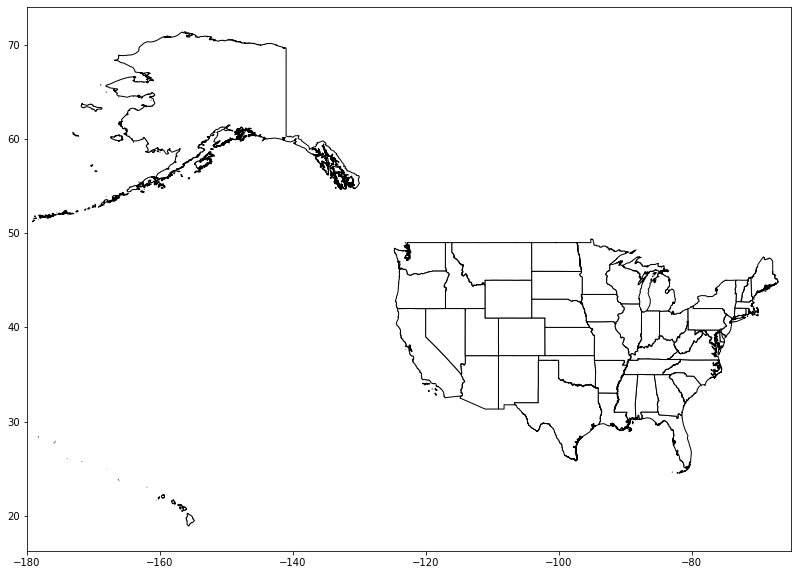

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
state.plot(ax=ax, edgecolor='k', facecolor='w')
plt.xlim(-180, -65)

Save as `GeoJSON`

In [ ]:
state.to_file('../data/state.json',driver='GeoJSON')

<a id='county'></a>
**`County` ([source](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_500k.zip)):**

In [9]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_county_500k.zip'
local_path = '../data/cb_2019_us_county_500k'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)
    
county = gpd.read_file(local_path+ '/' + 'cb_2019_us_county_500k.shp')
county = county.set_crs(epsg=4326, allow_override=True)
county = county.to_crs("EPSG:4326")
county.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
county = county[~county['STATEFP'].isin(['60','66','69', '72', '78'])]
county = county[['GEOID', 'STATEFP', 'COUNTYFP', 'NAME', 'geometry']]
county.columns = map(str.lower, county.columns)
print("Shape of the dataframe: {}".format(county.shape))
print("Projection of dataframe: {}".format(county.crs))

Shape of the dataframe: (3142, 5)
Projection of dataframe: epsg:4326


In [10]:
county

,geoid,statefp,countyfp,name,geometry
263,01001,01,001,Autauga,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
222,01003,01,003,Baldwin,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
166,01005,01,005,Barbour,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
2526,01007,01,007,Bibb,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
894,01009,01,009,Blount,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."
...,...,...,...,...,...
1826,56037,56,037,Sweetwater,"POLYGON ((-110.05438 42.01103, -110.05436 42.0..."
1163,56039,56,039,Teton,"POLYGON ((-111.05361 44.66627, -110.75076 44.6..."
1011,56041,56,041,Uinta,"POLYGON ((-111.04662 41.15604, -111.04659 41.2..."
2158,56043,56,043,Washakie,"POLYGON ((-108.55056 44.16845, -108.50652 44.1..."


**Add bbox**

In [11]:
county['bbox'] = county['geometry'].apply(lambda x: list(x.bounds))
# move level column
cols = county.columns.tolist()
county = county[cols[:len(cols)-2] + [cols[len(cols)-1]] + [cols[-2]]]
county = county.astype({'bbox': str})
county.head()

,geoid,statefp,countyfp,name,bbox,geometry
263,01001,01,001,Autauga,"[-86.921196, 32.307573999999995, -86.411172, 3...","POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
222,01003,01,003,Baldwin,"[-88.02857999999999, 30.223333999999998, -87.3...","POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
166,01005,01,005,Barbour,"[-85.748251, 31.617746999999998, -85.049309999...","POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
2526,01007,01,007,Bibb,"[-87.421989, 32.831522, -86.87611799999999, 33...","POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
894,01009,01,009,Blount,"[-86.963358, 33.765191, -86.303516, 34.2601699...","POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


(-180.0, -60.0)

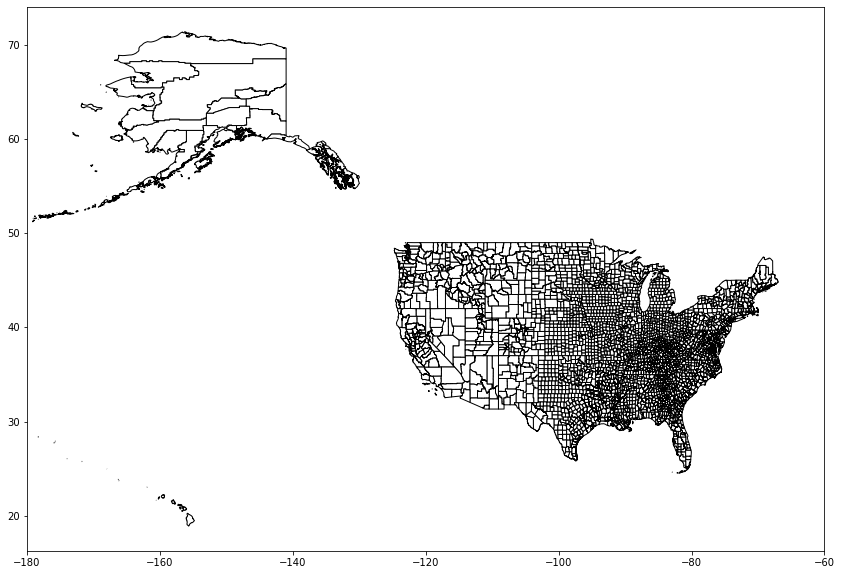

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
county.plot(ax=ax, edgecolor='k', facecolor='w')
plt.xlim(-180, -60)

Save as `GeoJSON`

In [ ]:
county.to_file('../data/county.json',driver='GeoJSON')

<a id='tract'></a>
**`Census tract` ([source](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_tract_500k.zip)):**

In [13]:
url = 'https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_tract_500k.zip'
local_path = '../data/cb_2019_us_tract_500k'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)
    
tract = gpd.read_file(local_path+ '/' + 'cb_2019_us_tract_500k.shp')
tract = tract.set_crs(epsg=4326, allow_override=True)
tract = tract.to_crs("EPSG:4326")
tract.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
tract = tract[~tract['STATEFP'].isin(['60','66','69', '72', '78'])]
tract = tract[['GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]
tract.columns = map(str.lower, tract.columns)
print("Shape of the dataframe: {}".format(tract.shape))
print("Projection of dataframe: {}".format(tract.crs))

Shape of the dataframe: (72831, 6)
Projection of dataframe: epsg:4326


In [14]:
tract

,geoid,statefp,countyfp,tractce,name,geometry
42627,01001020100,01,001,020100,201,"POLYGON ((-86.50916 32.47344, -86.50620 32.475..."
63036,01001020200,01,001,020200,202,"POLYGON ((-86.48093 32.48154, -86.47945 32.485..."
54564,01001020300,01,001,020300,203,"POLYGON ((-86.47087 32.47573, -86.46964 32.478..."
7300,01001020400,01,001,020400,204,"POLYGON ((-86.45394 32.49318, -86.45308 32.493..."
69399,01001020500,01,001,020500,205,"POLYGON ((-86.43816 32.45069, -86.43773 32.451..."
...,...,...,...,...,...,...
54829,56043000200,56,043,000200,2,"POLYGON ((-108.55056 44.16845, -108.50652 44.1..."
54828,56043000301,56,043,000301,3.01,"POLYGON ((-107.96412 44.01476, -107.95875 44.0..."
60929,56043000302,56,043,000302,3.02,"POLYGON ((-107.99537 43.98005, -107.99319 43.9..."
60252,56045951100,56,045,951100,9511,"POLYGON ((-105.08078 43.96622, -105.07928 44.1..."


**Add bbox**

In [15]:
tract['bbox'] = tract['geometry'].apply(lambda x: list(x.bounds))
# move level column
cols = tract.columns.tolist()
tract = tract[cols[:len(cols)-2] + [cols[len(cols)-1]] + [cols[-2]]]
tract = tract.astype({'bbox': str})
tract.head()

,geoid,statefp,countyfp,tractce,name,bbox,geometry
42627,01001020100,01,001,020100,201,"[-86.510291, 32.449726999999996, -86.475243999...","POLYGON ((-86.50916 32.47344, -86.50620 32.475..."
63036,01001020200,01,001,020200,202,"[-86.48113099999999, 32.456206, -86.4653759999...","POLYGON ((-86.48093 32.48154, -86.47945 32.485..."
54564,01001020300,01,001,020300,203,"[-86.470871, 32.459213999999996, -86.450679, 3...","POLYGON ((-86.47087 32.47573, -86.46964 32.478..."
7300,01001020400,01,001,020400,204,"[-86.453936, 32.44721, -86.43246099999999, 32....","POLYGON ((-86.45394 32.49318, -86.45308 32.493..."
69399,01001020500,01,001,020500,205,"[-86.43816199999999, 32.423997, -86.4113479999...","POLYGON ((-86.43816 32.45069, -86.43773 32.451..."


(-180.0, -60.0)

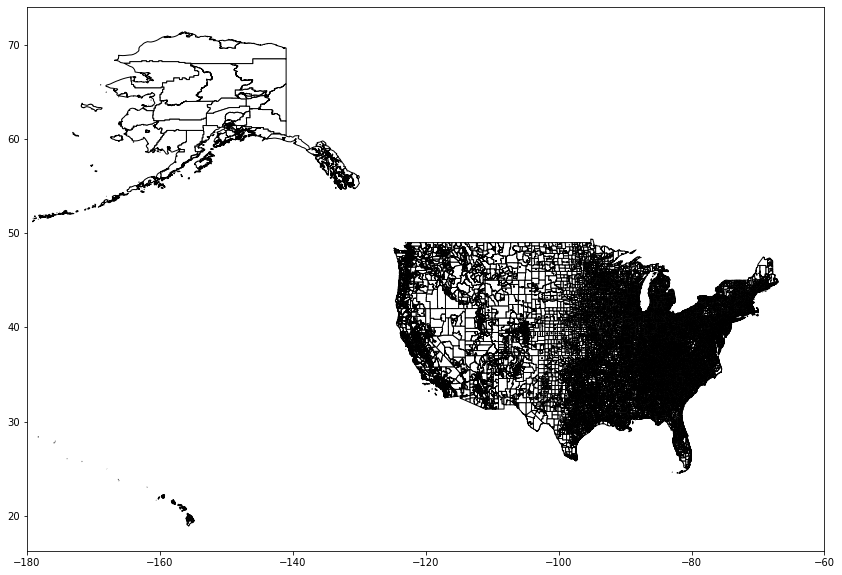

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
tract.plot(ax=ax, edgecolor='k', facecolor='w')
plt.xlim(-180, -60)

Save as `GeoJSON`

In [ ]:
tract.to_file('../data/tract.json',driver='GeoJSON')

### Save State and County names

In [ ]:
df = pd.merge(county[['geoid', 'statefp', 'name']], state[['statefp', 'name']], on='statefp', how='left')
df.rename(columns={'name_x': 'county', 'name_y': 'state'}, inplace=True)
d = (df.groupby('state')
       .apply(lambda x: list(x['county']))
       .to_dict())

with open('../data/state_county_names.json', 'w') as fp:
    json.dump(d, fp)

***
<a id='preprocess'></a>
## Preprocess data

<a id='carto_data'></a>
### 1. Carto data

#### Read data

In [19]:
# the four layers are provided from the same dataset
# search for the dataset
ds = lmi.Dataset(id_hash=datasets['carto']['riverine_flood_risk'])
ds

Dataset 5152c286-53c1-4583-9519-816a6e41889d Annual indicator layers

In [20]:
#get the layer from the dataset
l = ds.layers[0]
l

Layer d98ed153-b1d4-4793-bf4c-44cecbd63e53 Annual indicator layer

#### Use raw values

In [21]:
#build the sql to select the 4 attributes at the same time
account = l.attributes['layerConfig']['account']

query = "SELECT s.aq30_id, s.gid_1, s.pfaf_id, s.string_id, s.drr_label, s.drr_cat, s.drr_raw, s.drr_score, s.cfr_label, s.cfr_cat, s.cfr_raw, s.cfr_score, s.rfr_label, s.rfr_cat, s.rfr_raw, s.rfr_score, r.the_geom \
FROM water_risk_indicators_annual_all s \
LEFT JOIN y2018m12d06_rh_master_shape_v01 r on s.aq30_id=r.aq30_id \
WHERE s.pfaf_id != -9999 and s.gid_1 != '-9999' and r.aqid != -9999 and  s.gid_1 like 'USA%'"
df_input = df_from_carto(account, query)

df_input = df_input[['rfr_raw', 'cfr_raw', 'drr_raw', 'geometry']]

df_input.rename(columns={'rfr_raw': 'rfr', 'cfr_raw': 'cfr', 'drr_raw': 'drr'}, inplace=True)

df_input = df_input[['rfr', 'cfr', 'drr', 'geometry']]
# Reproject
df_input = df_input.set_crs(epsg=4326, allow_override=True)
df_input = df_input.to_crs("EPSG:4326")
df_input.head()

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,rfr,cfr,drr,geometry
0,0.000145,0.000000,2.251290,"MULTIPOLYGON (((-96.18414 32.28733, -96.20937 ..."
1,0.001058,0.000000,2.609344,"MULTIPOLYGON (((-88.07970 42.49762, -88.06250 ..."
2,0.001397,0.000000,1.917298,"MULTIPOLYGON (((-109.05656 38.84194, -109.0774..."
3,0.000019,0.000000,1.593548,"MULTIPOLYGON (((-119.47137 41.99273, -119.3232..."
4,0.001800,0.000041,1.931725,"MULTIPOLYGON (((-81.33521 31.33167, -81.33972 ..."


**Check the inputs**

(-180.0, -65.0)

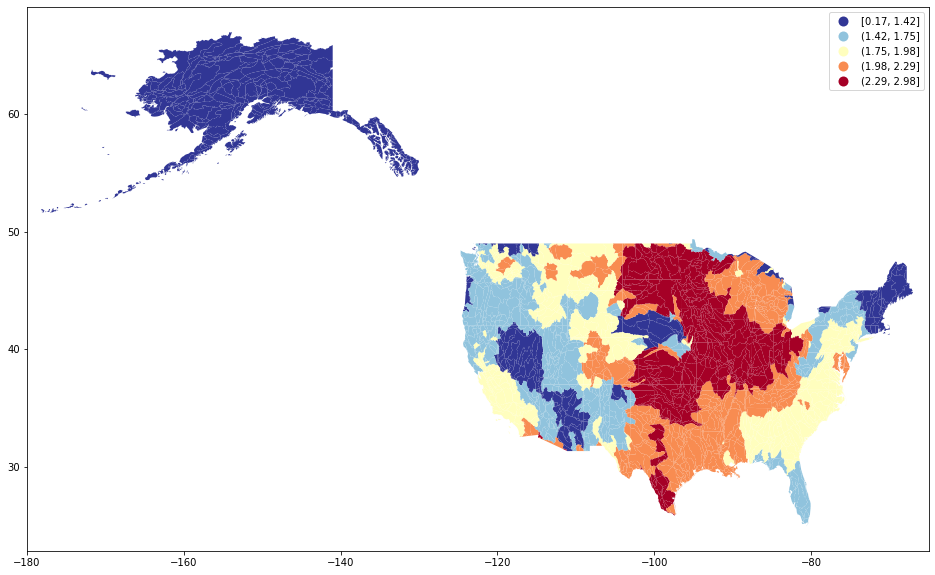

In [22]:
#check the outputs
name = 'drr'

fig, ax = plt.subplots(figsize=(20, 10))
df_input.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Intersect the geometries:

In [23]:
for n, df in enumerate([state, county]):
    df_tmp = gpd.overlay(df, df_input, how='intersection')
    df_tmp['level'] = n+1
    # move level column
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_out = df_tmp
    else:
        df_out = pd.concat([df_out, df_tmp])

#### Compute area of each geometry

In [24]:
df_out['area'] = df_out.area
df_out.head()

<ipython-input-24-930053a6e154>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_out['area'] = df_out.area


,level,geoid,statefp,name,bbox,rfr,cfr,drr,geometry,countyfp,area
0,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...",0.001398,0.0,1.775937,"POLYGON ((-86.68094 32.87074, -86.78000 32.938...",NaN,0.002294
1,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...",0.000035,0.0,1.906267,"POLYGON ((-84.97475 32.38001, -84.97382 32.379...",NaN,0.000003
2,1,13,13,Georgia,"[-85.605165, 30.357851, -80.83972899999999, 35...",0.000035,0.0,1.906267,"POLYGON ((-84.97265 32.37679, -84.97196 32.377...",NaN,0.079408
3,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...",0.001172,0.0,1.668289,"POLYGON ((-85.12791 31.00067, -85.14583 31.000...",NaN,0.000218
4,1,12,12,Florida,"[-87.63493799999999, 24.523096, -80.031362, 31...",0.001172,0.0,1.668289,"POLYGON ((-85.46329 30.99747, -85.40754 30.998...",NaN,0.163896


#### Weighted mean

In [25]:
# Weighted mean
df_tmp1 = weighted_mean(df_out[df_out['level'] == 1], columns=['rfr', 'cfr', 'drr'], weight_column='area', groupby_on='geoid')
# Merge with geometries
df_tmp1 = pd.merge(state, df_tmp1, on='geoid', how='left')
df_tmp1['level'] = 1
cols = df_tmp1.columns.tolist()
df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]

# Weighted mean
df_tmp2 = weighted_mean(df_out[df_out['level'] == 2], columns=['rfr', 'cfr', 'drr'], weight_column='area', groupby_on='geoid')
# Merge with geometries
df_tmp2 = pd.merge(county, df_tmp2, on='geoid', how='left')
df_tmp2['level'] = 2
cols = df_tmp2.columns.tolist()
df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]

df_carto = pd.concat([df_tmp1, df_tmp2])

df_carto.head()

,level,geoid,statefp,name,bbox,geometry,rfr,cfr,drr,countyfp
0,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",0.000623,0.000002,1.844421,NaN
1,1,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287...",0.006045,0.000197,NaN,NaN
2,1,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5...",0.001060,0.000012,1.453468,NaN
3,1,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499...",0.001175,0.000000,2.122969,NaN
4,1,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",0.002185,0.000004,1.789618,NaN


**Export temporal json data with carto processing**

In [ ]:
#export temporal json data with carto processing
df_out.to_file(
    '../data/carto_data.json',
    driver='GeoJSON')

**Check the outputs**

`States`:

(-180.0, -65.0)

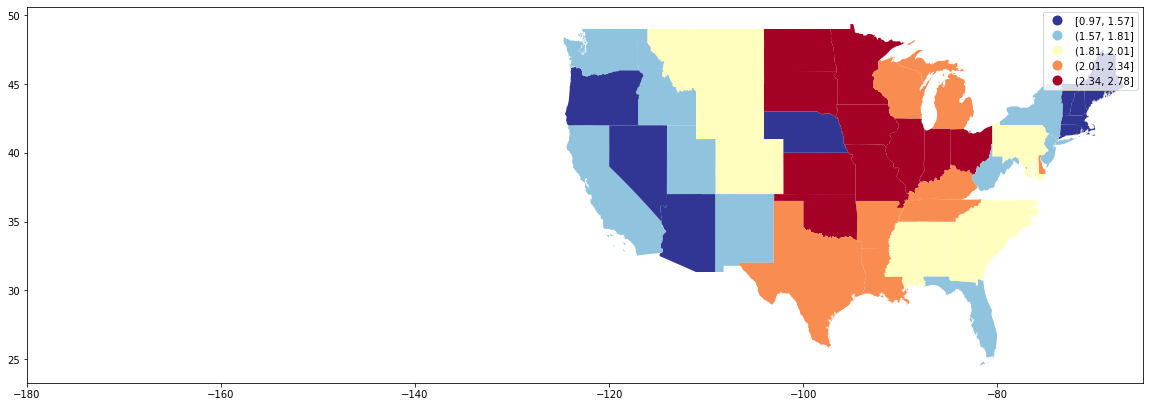

In [26]:
#check the outputs
name = 'drr'
df = df_carto[df_carto['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Counties`:

(-180.0, -65.0)

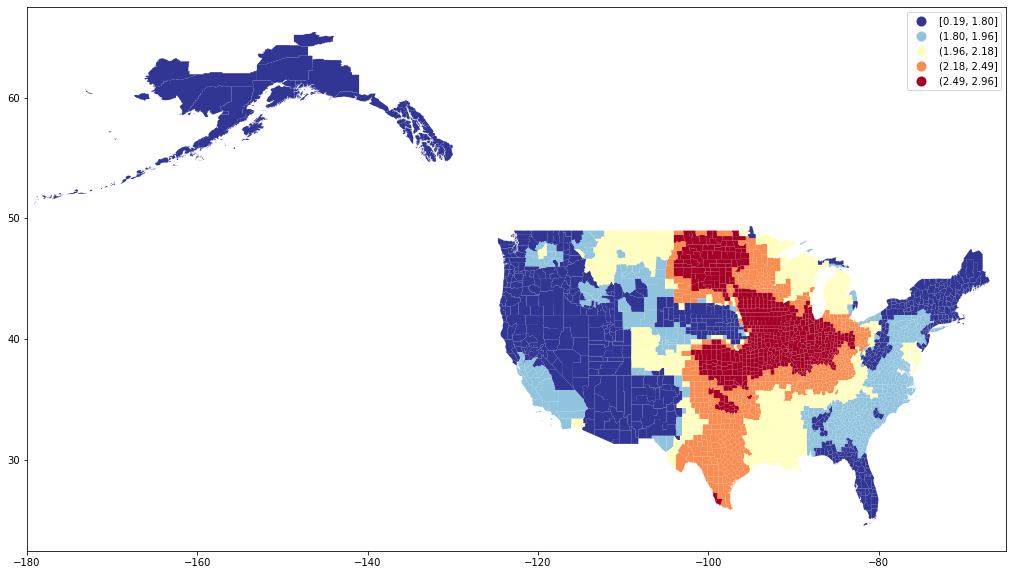

In [27]:
name = 'drr'
df = df_carto[df_carto['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Compute scores category and ranges:

In [30]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
        
df_tmp1  = compute_score_category_label(df_carto[df_carto['level'] == 1], columns=['rfr', 'cfr', 'drr'], q=q, scores=scores)
df_tmp2 = compute_score_category_label(df_carto[df_carto['level'] == 2], columns=['rfr', 'cfr', 'drr'], q=q, scores=scores)

df_out_carto = pd.concat([df_tmp1, df_tmp2])

quantiles used for aggregate total: 0.0    0.000282
0.2    0.000844
0.4    0.001296
0.6    0.001849
0.8    0.002513
1.0    0.006045
Name: rfr, dtype: float64
quantiles used for aggregate total: 0.0    1.030952e-07
0.2    3.498335e-06
0.4    1.130276e-05
0.6    1.779906e-05
0.8    4.125190e-05
1.0    1.420807e-03
Name: cfr, dtype: float64
quantiles used for aggregate total: 0.0    0.974009
0.2    1.566900
0.4    1.807778
0.6    2.006688
0.8    2.337704
1.0    2.778983
Name: drr, dtype: float64
quantiles used for aggregate total: 0.0    0.000005
0.2    0.000422
0.4    0.000798
0.6    0.001273
0.8    0.002186
1.0    0.015802
Name: rfr, dtype: float64
quantiles used for aggregate total: 0.0    6.163258e-12
0.2    6.517923e-07
0.4    6.237289e-06
0.6    2.370798e-05
0.8    6.038666e-05
1.0    1.524237e-02
Name: cfr, dtype: float64


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


quantiles used for aggregate total: 0.0    0.186447
0.2    1.795876
0.4    1.960790
0.6    2.184034
0.8    2.492924
1.0    2.957509
Name: drr, dtype: float64


In [31]:
df_out_carto.sort_values(['level','geoid'], inplace=True)

**Check the outputs**

`States`:

(-180.0, -65.0)

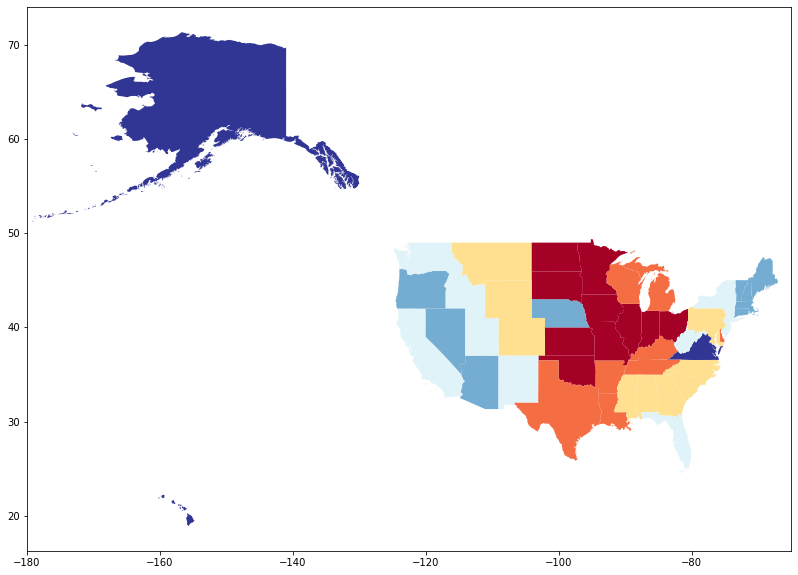

In [32]:
#check the outputs
name = 'drr_cat'
df = df_out_carto[df_out_carto['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)

`Counties`:

(-180.0, -65.0)

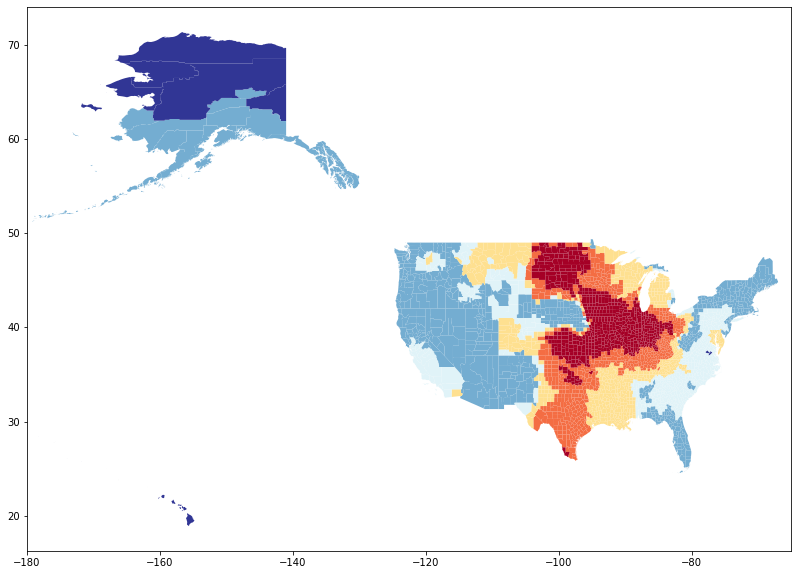

In [33]:
#check the outputs
name = 'drr_cat'
df = df_out_carto[df_out_carto['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

#### Use scores

In [35]:
#build the sql to select the 4 attributes at the same time
account = l.attributes['layerConfig']['account']
query = "SELECT s.aq30_id, s.gid_1, s.pfaf_id, s.string_id, s.drr_label, s.drr_cat, s.drr_raw, s.drr_score, s.cfr_label, s.cfr_cat, s.cfr_raw, s.cfr_score, s.rfr_label, s.rfr_cat, s.rfr_raw, s.rfr_score, r.the_geom \
FROM water_risk_indicators_annual_all s \
LEFT JOIN y2018m12d06_rh_master_shape_v01 r on s.aq30_id=r.aq30_id \
WHERE s.pfaf_id != -9999 and s.gid_1 != '-9999' and r.aqid != -9999 and  s.gid_1 like 'USA%'"
df_input = df_from_carto(account, query)
df_input = df_input[['rfr_score', 'cfr_score', 'drr_score', 'geometry']]

# Reproject
df_input = df_input.set_crs(epsg=4326, allow_override=True)
df_input = df_input.to_crs("EPSG:4326")
df_input.head()

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,rfr_score,cfr_score,drr_score,geometry
0,0.122669,0.000000,2.251290,"MULTIPOLYGON (((-96.18414 32.28733, -96.20937 ..."
1,0.895089,0.000000,2.609344,"MULTIPOLYGON (((-88.07970 42.49762, -88.06250 ..."
2,1.119542,0.000000,1.917298,"MULTIPOLYGON (((-109.05656 38.84194, -109.0774..."
3,0.016365,0.000000,1.593548,"MULTIPOLYGON (((-119.47137 41.99273, -119.3232..."
4,1.342539,1.507577,1.931725,"MULTIPOLYGON (((-81.33521 31.33167, -81.33972 ..."


#### Intersect the geometries:

In [36]:
for n, df in enumerate([state, county, tract]):
    df_tmp = gpd.overlay(df, df_input, how='intersection')
    df_tmp['level'] = n+1
    # move level column
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_out = df_tmp
    else:
        df_out = pd.concat([df_out, df_tmp])

#### Compute area of each geometry

In [37]:
df_out['area'] = df_out.area
df_out.head()

<ipython-input-37-930053a6e154>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_out['area'] = df_out.area


,level,geoid,statefp,name,bbox,rfr_score,cfr_score,drr_score,geometry,countyfp,tractce,area
0,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...",1.119658,0.0,1.775937,"POLYGON ((-86.68094 32.87074, -86.78000 32.938...",NaN,NaN,0.002294
1,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...",0.029310,0.0,1.906267,"POLYGON ((-84.97475 32.38001, -84.97382 32.379...",NaN,NaN,0.000003
2,1,13,13,Georgia,"[-85.605165, 30.357851, -80.83972899999999, 35...",0.029310,0.0,1.906267,"POLYGON ((-84.97265 32.37679, -84.97196 32.377...",NaN,NaN,0.079408
3,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...",0.991893,0.0,1.668289,"POLYGON ((-85.12791 31.00067, -85.14583 31.000...",NaN,NaN,0.000218
4,1,12,12,Florida,"[-87.63493799999999, 24.523096, -80.031362, 31...",0.991893,0.0,1.668289,"POLYGON ((-85.46329 30.99747, -85.40754 30.998...",NaN,NaN,0.163896


#### Weighted mean

In [38]:
for n, df in enumerate([state, county, tract]):
    # Weighted mean
    df_tmp = weighted_mean(df_out[df_out['level'] == n+1], columns=['rfr_score', 'cfr_score', 'drr_score'], weight_column='area', groupby_on='geoid')
    # Merge with geometries
    df_tmp = pd.merge(df, df_tmp, on='geoid', how='left')
    df_tmp['level'] = n+1
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_carto = df_tmp
    else:
        df_carto = pd.concat([df_carto, df_tmp])
        
df_carto

,level,geoid,statefp,name,bbox,geometry,rfr_score,cfr_score,drr_score,countyfp,tractce
0,1,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",0.502981,0.089206,1.844421,NaN,NaN
1,1,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287...",1.692572,0.363021,NaN,NaN,NaN
2,1,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5...",0.680378,0.024659,1.453468,NaN,NaN
3,1,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499...",0.839422,0.000000,2.122969,NaN,NaN
4,1,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",1.179035,0.110282,1.789618,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
72826,3,56043000200,56,2,"[-108.550758, 43.500259, -107.110734, 44.16845...","POLYGON ((-108.55056 44.16845, -108.50652 44.1...",1.986667,0.000000,1.745136,043,000200
72827,3,56043000301,56,3.01,"[-107.968767, 44.007878999999996, -107.948397,...","POLYGON ((-107.96412 44.01476, -107.95875 44.0...",2.006692,0.000000,1.742561,043,000301
72828,3,56043000302,56,3.02,"[-107.99537, 43.975749, -107.921626, 44.063372]","POLYGON ((-107.99537 43.98005, -107.99319 43.9...",2.006692,0.000000,1.742561,043,000302
72829,3,56045951100,56,9511,"[-105.081407, 43.498445, -104.054597, 44.181622]","POLYGON ((-105.08078 43.96622, -105.07928 44.1...",0.211906,0.000000,1.895009,045,951100


#### Compute category and ranges:

In [39]:
for indicator in ['rfr', 'cfr', 'drr']:
    df_carto[indicator] = df_carto[f'{indicator}_score']
    
for n in df_carto['level'].unique():
    df_tmp  = compute_category_label(df_carto[df_carto['level'] == n], columns=['rfr', 'cfr', 'drr'])

    if n == 1:
        df_out_carto = df_tmp
    else:
        df_out_carto = pd.concat([df_out_carto, df_tmp])

df_out_carto

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,level,geoid,statefp,name,bbox,geometry,rfr_score,cfr_score,drr_score,countyfp,tractce,rfr,cfr,drr,rfr_cat,rfr_range,cfr_cat,cfr_range,drr_cat,drr_range
11,1,15,15,Hawaii,"[-178.334698, 18.910360999999998, -154.806773,...","MULTIPOLYGON (((-156.06076 19.73055, -156.0566...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Data not available,-1,Data not available,-1,Data not available
46,1,51,51,Virginia,"[-83.675395, 36.540738, -75.242266, 39.466012]","MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",0.613053,0.118303,NaN,NaN,NaN,0.613053,0.118303,NaN,0,"[0, 1]",0,"[0, 1]",-1,Data not available
1,1,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287...",1.692572,0.363021,NaN,NaN,NaN,1.692572,0.363021,NaN,1,"[1, 2]",0,"[0, 1]",-1,Data not available
19,1,23,23,Maine,"[-71.083924, 42.977764, -66.949895, 47.459686]","MULTIPOLYGON (((-67.32259 44.61160, -67.32174 ...",1.996216,0.176779,0.974009,NaN,NaN,1.996216,0.176779,0.974009,1,"[1, 2]",0,"[0, 1]",0,"[0, 1]"
29,1,33,33,New Hampshire,"[-72.55724699999999, 42.69699, -70.610621, 45....","MULTIPOLYGON (((-70.61702 42.97718, -70.61529 ...",1.072468,0.337894,1.183267,NaN,NaN,1.072468,0.337894,1.183267,1,"[1, 2]",0,"[0, 1]",1,"[1, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26037,3,19153001500,19,15,"[-93.62530699999999, 41.607389, -93.600537, 41...","POLYGON ((-93.62478 41.61549, -93.62479 41.619...",2.039313,0.000000,2.981934,153,001500,2.039313,0.000000,2.981934,2,"[2, 3]",0,"[0, 1]",2,"[2, 3]"
26027,3,19153000703,19,7.03,"[-93.678038, 41.614914999999996, -93.658525, 4...","POLYGON ((-93.67804 41.62950, -93.67201 41.629...",2.039313,0.000000,2.981934,153,000703,2.039313,0.000000,2.981934,2,"[2, 3]",0,"[0, 1]",2,"[2, 3]"
26028,3,19153000704,19,7.04,"[-93.678253, 41.629495999999996, -93.661812, 4...","POLYGON ((-93.67825 41.64733, -93.67147 41.646...",2.039313,0.000000,2.981934,153,000704,2.039313,0.000000,2.981934,2,"[2, 3]",0,"[0, 1]",2,"[2, 3]"
25574,3,19015020400,19,204,"[-93.915561, 42.034863, -93.893052, 42.0710039...","POLYGON ((-93.91556 42.06737, -93.90299 42.067...",2.039313,0.000000,2.981934,015,020400,2.039313,0.000000,2.981934,2,"[2, 3]",0,"[0, 1]",2,"[2, 3]"


In [40]:
df_out_carto.sort_values(['level','geoid'], inplace=True)

In [ ]:
df_out_carto.to_csv('../data/carto_indicators.csv')

**Check the outputs**

`States`:

(-180.0, -65.0)

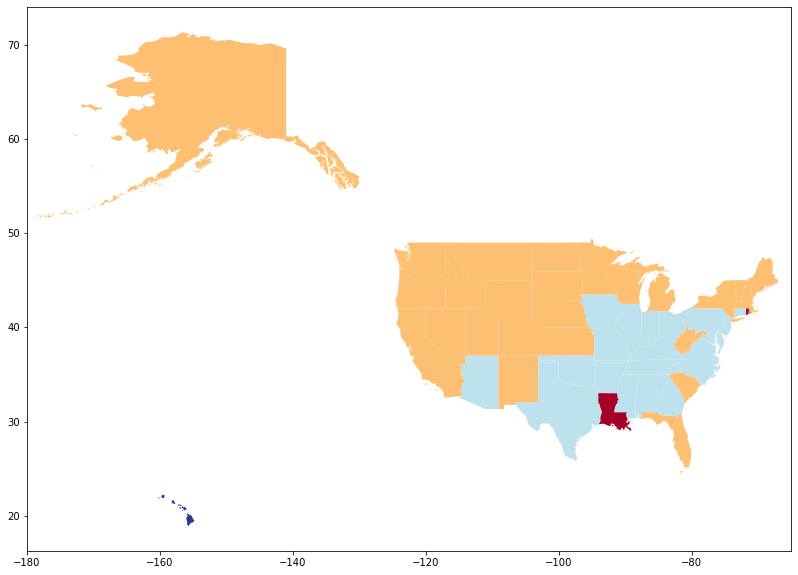

In [41]:
#check the outputs
name = 'rfr_cat'
df = df_out_carto[df_out_carto['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)

`Counties`:

(-180.0, -65.0)

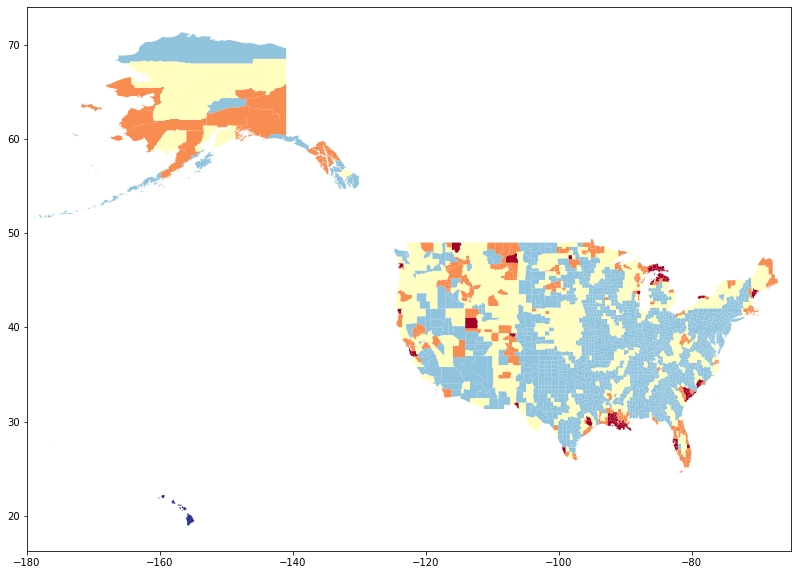

In [42]:
#check the outputs
name = 'rfr_cat'
df = df_out_carto[df_out_carto['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Census tracts`:

(-180.0, -65.0)

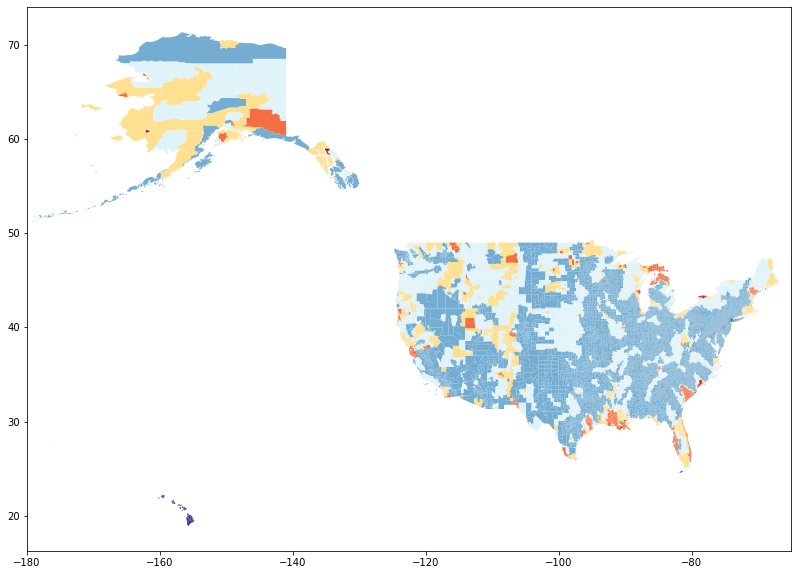

In [43]:
#check the outputs
name = 'rfr_cat'
df = df_out_carto[df_out_carto['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

In [ ]:
df_out_carto.to_csv('../data/carto_indicators.csv')

In [ ]:
#export temporal json data with carto processing
df_out_cat.to_file(
    '../data/carto_data_cat.json',
    driver='GeoJSON')

<a id='wildfire_data'></a>
### 2. [Wildfire data](https://www.nature.com/articles/s41597-019-0312-2):

- Data source: data is available in [this PANGAEA repository](https://doi.pangaea.de/10.1594/PANGAEA.895835)

#### Read data

In [44]:
wildfires = gpd.read_file('../data/wildfires/wildfires.shp')
wildfires.head()

,IDate,Type,Id,FDate,geometry
0,2001-01-01,FinalArea,160108,2001-01-04,"POLYGON ((-121.01367 56.22754, -121.01367 56.2..."
1,2001-01-02,FinalArea,160109,2001-01-05,"POLYGON ((-121.04883 56.21436, -121.03125 56.2..."
2,2001-01-02,FinalArea,160110,2001-01-02,"POLYGON ((-121.01367 56.20557, -121.00488 56.2..."
3,2001-01-02,FinalArea,160111,2001-01-02,"POLYGON ((-120.95215 56.20557, -120.94336 56.2..."
4,2001-01-05,FinalArea,160112,2001-01-05,"POLYGON ((-121.91455 56.19678, -121.90576 56.1..."


####  Intersect the geometries:

In [1]:
for n, df in enumerate([state, county, tract]):
    number_fires, mean_fire_size, total_fire_size, per_total_fire_size = rtree_intersect(wildfires, df)
    
    df_tmp = df.copy()
    df_tmp['number_wlf'] = number_fires
    df_tmp['mean_size_wlf'] = mean_fire_size
    df_tmp['total_size_wlf'] = total_fire_size
    df_tmp['per_total_size_wlf'] = per_total_fire_size
    df_tmp['level'] = n+1 
    # move level column
    cols = df_tmp.columns.tolist()
    df_tmp = df_tmp[cols[-1:] + cols[:-1]]
    
    if n == 0:
        df_out = df_tmp
    else:
        df_out = pd.concat([df_out, df_tmp])
        
df_out.head()

NameError: name 'state' is not defined

In [ ]:
df_out

In [ ]:
df_out = df_out.rename(columns={'total_size_wlf': 'wlf'})
df_out = df_out[['level', 'geoid', 'statefp', 'name', 'bbox', 'geometry', 'countyfp', 'wlf']]

**Check the outputs**

`States`:

In [ ]:
#check the outputs
df = df_out[df_out['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot('total_wlf_per', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Counties`:

In [ ]:
#check the outputs
df = df_out[df_out['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot('total_wlf_per', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Census tracts`:

In [ ]:
#check the outputs
df = df_out[df_out['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot('total_wlf_per', ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Compute scores category and ranges:

In [ ]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
    
for n in df_carto['level'].unique():
    df_tmp  = compute_score_category_label(df_out[df_out['level'] == n], columns=['wlf'], q=q, scores=scores)

    if n == 1:
        df_out_wlf = df_tmp
    else:
        df_out_wlf = pd.concat([df_out_wlf, df_tmp])

df_out_wlf

In [ ]:
df_out_wlf.sort_values(['level','geoid'], inplace=True)
df_out_wlf.to_csv('../data/wlf_indicators.csv')

**Check the outputs**

`States`:

In [ ]:
#check the outputs
name = 'wlf_cat'
df = df_out_wlf[df_out_wlf['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`

In [ ]:
#check the outputs
name = 'wlf_cat'
df = df_out_wlf[df_out_wlf['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Census tracts`

In [ ]:
#check the outputs
name = 'wlf_cat'
df = df_out_wlf[df_out_wlf['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

<a id='gee_data'></a>
### 3. GEE data:
#### Read `xarray.Dataset` from `TIFF` in GCS

In [17]:
file_names = {"efd": "dis.004_Earthquake_Frequency_and_Distribution.tif",
              "lss": "dis.007_Landslide_Susceptibility_replacement.tif",
              "vfd": "dis.008_Volcano_Frequency_and_Distribution.tif",
              "ehd": "cli.056a_Projected_Change_in_Extreme_Heat_Days.tif",
              "epd": "cli.059a_Projected_Change_in_Extreme_Precipitation_Days.tif"}

In [18]:
datasets = {}
base_url = 'https://storage.googleapis.com/us-resilience-map/datasets/'
for name, file_name in file_names.items():
    print(f"Read xarray.Dataset from {file_name}")
    url = f'{base_url}{file_name}'
    xda = xr.open_rasterio(url).squeeze().drop("band")
    
    if name == 'ehd':
        # Replace all values equal to 0 with np.nan
        xda = xda.where(xda != 0.)
    else:
        # Replace all values equal to -9999 with np.nan
        xda = xda.where(xda != -9999.)
    
    # Rename coordinates 
    xda = xda.rename({'x': 'lon', 'y': 'lat'})
    
    # Convert the DataArray to a Dataset.
    ds = xda.to_dataset(name=name)
    
    datasets[name] = ds

Read xarray.Dataset from dis.004_Earthquake_Frequency_and_Distribution.tif
Read xarray.Dataset from dis.007_Landslide_Susceptibility_replacement.tif
Read xarray.Dataset from dis.008_Volcano_Frequency_and_Distribution.tif
Read xarray.Dataset from cli.056a_Projected_Change_in_Extreme_Heat_Days.tif
Read xarray.Dataset from cli.059a_Projected_Change_in_Extreme_Precipitation_Days.tif


**Check data**

`Landslide Susceptibility`:

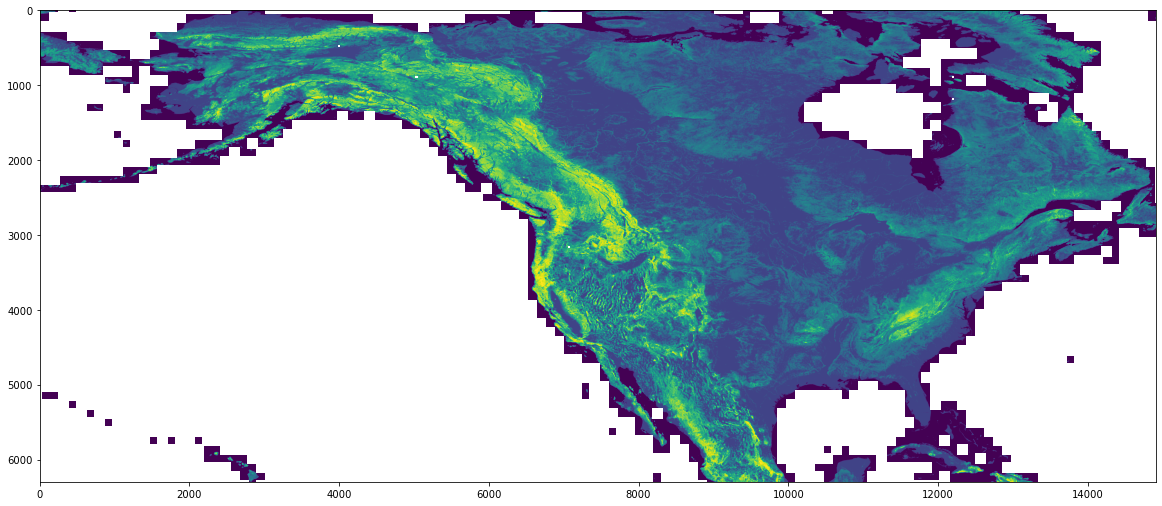

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(datasets['lss']['lss'].values)

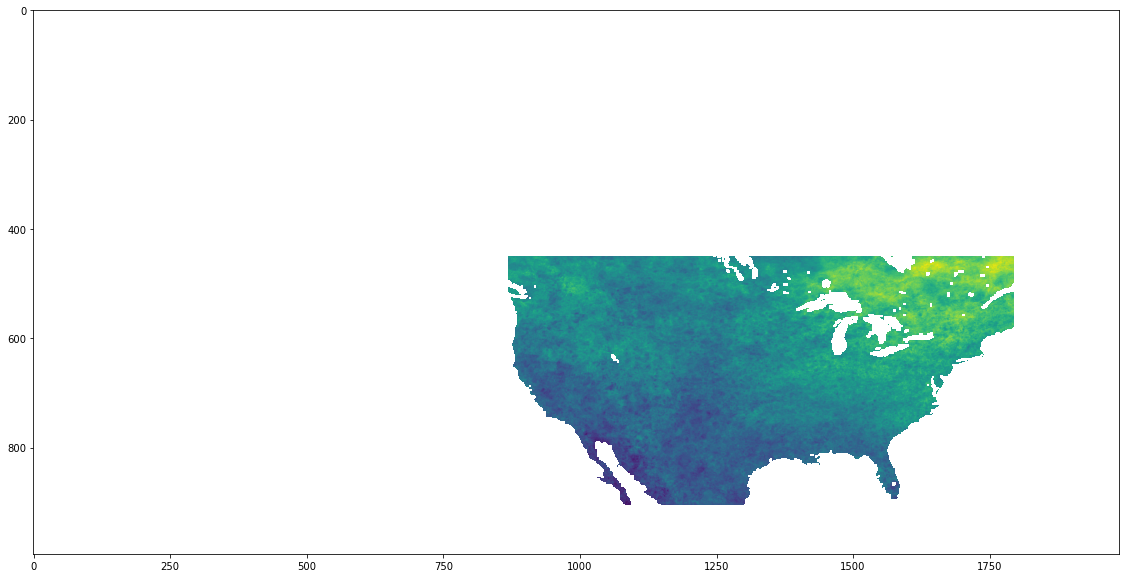

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(datasets['epd']['epd'].values)

#### Zonal statistics
**Create the data mask by rasterizing the vector data**

In [21]:
masks = {'state': state,
        'county': county,
        'tract': tract}

for n, dataset in enumerate(datasets.items()):
    ds_name = dataset[0]
    ds = dataset[1]
    print(f"Creating data masks in {ds_name}")
    for mask_name, df in masks.items():
        df = masks[mask_name]
        df = df.reset_index().drop(columns='index').reset_index()
        print(f"Creating the data mask by rasterizing the vector data for {mask_name}")
        # Create the data mask by rasterizing the vector data
        ds[mask_name], index = create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat')
        
        # Compute the mean value inside each geometry
        print(f"Computing the mean value inside each geometry")
        grouped_ds = ds.groupby(ds[mask_name])
        grid_mean = grouped_ds.mean()
        df_mean = grid_mean.to_dataframe()
        
        df_mean = df_mean[[ds_name]].reset_index().rename(columns={mask_name: 'index'})

        # Get centroid value for geometries smaller than mean cell size
        print(f"Getting centroid value for geometries smaller than mean cell size")
        if len(index) > 0:
            df_others = df[df['index'].isin(index)][['index', 'geometry']].copy()
            df_others['centroid'] = df['geometry'].apply(lambda x: list(x.centroid.coords)[0])

            values = []
            for centroid in  tqdm(df_others['centroid']):
                values.append(float(ds[ds_name].interp(lat=centroid[1], lon=centroid[0]).values))

            df_others[ds_name] = values
            df_mean = pd.concat([df_mean,df_others[['index', ds_name]]]).sort_values('index')  
            
        # Merge values with geometry GeoDataFrame
        if mask_name == 'state':
            if n == 0:
                df_tmp1 = pd.merge(df, df_mean, on='index', how='left')
                df_tmp1['level'] = 1
                cols = df_tmp1.columns.tolist()
                df_tmp1 = df_tmp1[cols[-1:] + cols[:-1]]
            else:
                df_tmp1[ds_name] = list(df_mean[ds_name])
        elif mask_name == 'county':
            if n == 0:
                df_tmp2 = pd.merge(df, df_mean, on='index', how='left')
                df_tmp2['level'] = 2
                cols = df_tmp2.columns.tolist()
                df_tmp2 = df_tmp2[cols[-1:] + cols[:-1]]
            else:
                df_tmp = pd.merge(df, df_mean, on='index', how='left')
                df_tmp2[ds_name] = list(df_tmp[ds_name])
        else:
            if n == 0:
                df_tmp3 = pd.merge(df, df_mean, on='index', how='left')
                df_tmp3['level'] = 3
                cols = df_tmp3.columns.tolist()
                df_tmp3 = df_tmp3[cols[-1:] + cols[:-1]]
            else:
                df_tmp = pd.merge(df, df_mean, on='index', how='left')
                df_tmp3[ds_name] = list(df_tmp[ds_name])
            
df_out = pd.concat([df_tmp1, df_tmp2, df_tmp3])

Creating data masks in efd
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 0.001736 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51
Number of ints in mask: 51
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 0.001736 deg.

Clipped gdf to dataset bounds, giving 3142 potential geometries, of which 3136 are large enough.

Geometries smaller than mean cell size:
      index
2917   2917
2921   2921
2924   2924
2925   2925
2932   2932
2935   2935


Number of indexes: 3136
Number of geoms: 3136


<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Number of ints in mask: 3136
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
  0%|          | 0/6 [00:00<?, ?it/s]

Getting centroid value for geometries smaller than mean cell size


100%|██████████| 6/6 [00:00<00:00, 22.62it/s]


Creating the data mask by rasterizing the vector data for tract
The mean ds cell area is 0.001736 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 72831 potential geometries, of which 23537 are large enough.

Geometries smaller than mean cell size:
       index
0          0
1          1
2          2
3          3
4          4
...      ...
72809  72809
72813  72813
72814  72814
72816  72816
72827  72827

[49294 rows x 1 columns]


Number of indexes: 23537
Number of geoms: 23537
Number of ints in mask: 23095
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size


100%|██████████| 49294/49294 [29:02<00:00, 28.29it/s]  


Creating data masks in lss
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 6.9e-05 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51
Number of ints in mask: 51
Computing the mean value inside each geometry
Getting centroid value for geometries smaller than mean cell size
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 6.9e-05 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 3142 potential geometries, of which 3142 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 3142
Number of geoms: 3142
Number of ints in mask: 3142
Computing the mean value inside each geometry
Getting centroid value for geometries smaller than mean cell size
Creating the data mask by rasterizing the vector data for tract
The mean ds cell area is 6.9e-05 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 72831 potential geometries, of which 66929 are large enough.

Geometries smaller than mean cell size:
       index
755      755
1609    1609
1720    1720
1721    1721
1728    1728
...      ...
72149  72149
72155  72155
72156  72156
72252  72252
72583  72583

[5902 rows x 1 columns]


Number of indexes: 66929
Number of geoms: 66929
Number of ints in mask: 66271
Computing the mean value inside each geometry
Getting centroid value for geometries smaller than mean cell size


100%|██████████| 5902/5902 [2:23:33<00:00,  1.46s/it]  


Creating data masks in vfd
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 0.001736 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51
Number of ints in mask: 51
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 0.001736 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 3142 potential geometries, of which 3136 are large enough.

Geometries smaller than mean cell size:
      index
2917   2917
2921   2921
2924   2924
2925   2925
2932   2932
2935   2935


Number of indexes: 3136
Number of geoms: 3136
Number of ints in mask: 3136
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size


100%|██████████| 6/6 [00:00<00:00, 13.90it/s]


Creating the data mask by rasterizing the vector data for tract
The mean ds cell area is 0.001736 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 72831 potential geometries, of which 23537 are large enough.

Geometries smaller than mean cell size:
       index
0          0
1          1
2          2
3          3
4          4
...      ...
72809  72809
72813  72813
72814  72814
72816  72816
72827  72827

[49294 rows x 1 columns]


Number of indexes: 23537
Number of geoms: 23537
Number of ints in mask: 23095
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size


100%|██████████| 49294/49294 [1:01:41<00:00, 13.32it/s]


Creating data masks in ehd
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 0.003906 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51
Number of ints in mask: 51
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 0.003906 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 3142 potential geometries, of which 3120 are large enough.

Geometries smaller than mean cell size:
      index
548     548
2916   2916
2917   2917
2918   2918
2920   2920
2921   2921
2923   2923
2924   2924
2925   2925
2926   2926
2927   2927
2928   2928
2931   2931
2932   2932
2934   2934
2935   2935
2936   2936
2939   2939
2943   2943
2946   2946
2951   2951
2952   2952


Number of indexes: 3120
Number of geoms: 3120
Number of ints in mask: 3119
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size


100%|██████████| 22/22 [00:00<00:00, 33.70it/s]


Creating the data mask by rasterizing the vector data for tract
The mean ds cell area is 0.003906 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 72831 potential geometries, of which 17856 are large enough.

Geometries smaller than mean cell size:
       index
0          0
1          1
2          2
3          3
4          4
...      ...
72814  72814
72816  72816
72817  72817
72827  72827
72828  72828

[54975 rows x 1 columns]


Number of indexes: 17856
Number of geoms: 17856
Number of ints in mask: 17545
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size


100%|██████████| 54975/54975 [19:54<00:00, 46.04it/s]  


Creating data masks in epd
Creating the data mask by rasterizing the vector data for state
The mean ds cell area is 0.003906 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 51 potential geometries, of which 51 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 51
Number of geoms: 51
Number of ints in mask: 51
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size
Creating the data mask by rasterizing the vector data for county
The mean ds cell area is 0.003906 deg.

Clipped gdf to dataset bounds, giving 3142 potential geometries, of which 3120 are large enough.

Geometries smaller than mean cell size:
      index
548     548
2916   2916
2917   2917
2918   2918
2920   2920
2921   2921
2923   2923
2924   2924
2925   2925
2926   2926
2927   2927
2928   2928
2931   2931
2932   2932
2934   2934
2935   2935
2936   2936
2939   2939
2943   2943
2946   2946
2951   2951
2952   2952


Number of indexes: 3120
Number of geoms: 3120


<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Number of ints in mask: 3119
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
  0%|          | 0/22 [00:00<?, ?it/s]

Getting centroid value for geometries smaller than mean cell size


100%|██████████| 22/22 [00:00<00:00, 56.46it/s]


Creating the data mask by rasterizing the vector data for tract
The mean ds cell area is 0.003906 deg.



<ipython-input-4-9d29ab5693b9>:227: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area = df.area)


Clipped gdf to dataset bounds, giving 72831 potential geometries, of which 17856 are large enough.

Geometries smaller than mean cell size:
       index
0          0
1          1
2          2
3          3
4          4
...      ...
72814  72814
72816  72816
72817  72817
72827  72827
72828  72828

[54975 rows x 1 columns]


Number of indexes: 17856
Number of geoms: 17856
Number of ints in mask: 17545
Computing the mean value inside each geometry


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Getting centroid value for geometries smaller than mean cell size


100%|██████████| 54975/54975 [14:22<00:00, 63.76it/s]


In [22]:
df_out.head()

,level,index,geoid,statefp,name,bbox,geometry,efd,lss,vfd,ehd,epd,countyfp,tractce
0,1,0,01,01,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1.000000,1.778780,NaN,19.282116,1.065365,NaN,NaN
1,1,1,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287...",3.396378,2.245384,NaN,NaN,NaN,NaN,NaN
2,1,2,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5...",1.603448,2.081928,1.000000,16.026979,1.026377,NaN,NaN
3,1,3,05,05,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499...",1.000000,1.684156,NaN,15.466302,1.094659,NaN,NaN
4,1,4,06,06,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",4.544063,2.721891,2.611465,11.713603,1.027158,NaN,NaN


**Check the outputs**

`States`:

(-180.0, -65.0)

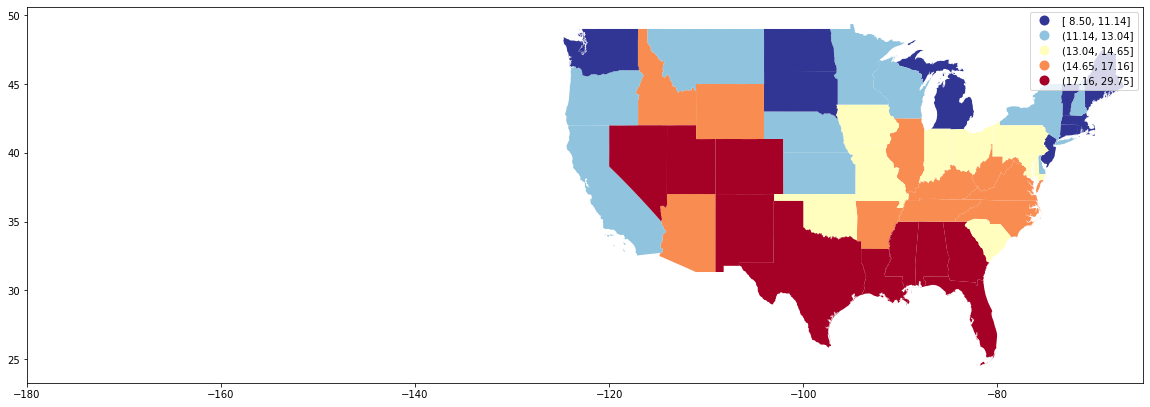

In [23]:
name = 'ehd'
df = df_out[df_out['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Counties`:

(-180.0, -65.0)

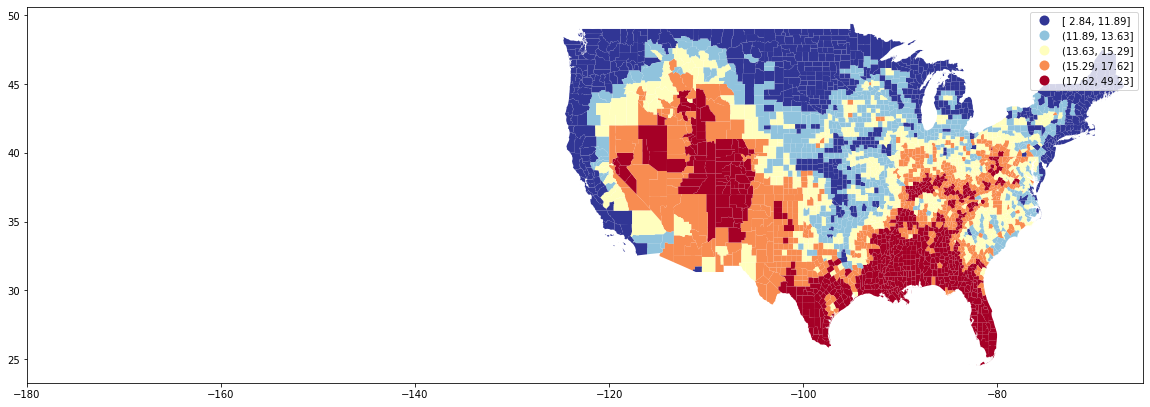

In [24]:
df = df_out[df_out['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

`Census tract`:

(-180.0, -65.0)

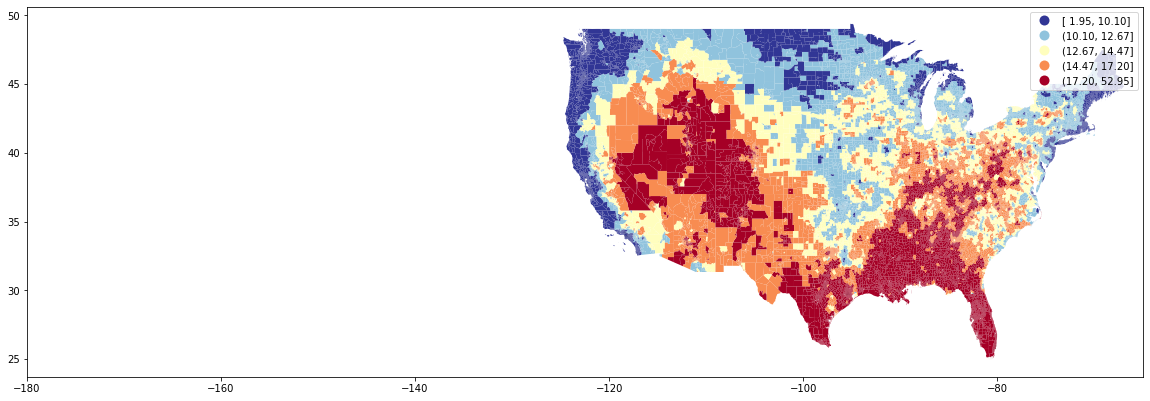

In [25]:
df = df_out[df_out['level'] == 3].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r", scheme='quantiles', legend=True)
plt.xlim(-180, -65)

#### Compute scores category and labels:

In [26]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]
    
for n in df_out['level'].unique():
    df_tmp  = compute_score_category_label(df_out[df_out['level'] == n], columns=['lss', 'ehd', 'epd'], q=q, scores=scores)

    if n == 1:
        df_out_score = df_tmp
    else:
        df_out_score = pd.concat([df_out_score, df_tmp])

df_out_score

quantiles used for aggregate total: 0.0    1.041261
0.2    1.368671
0.4    1.638110
0.6    2.054083
0.8    2.387767
1.0    3.195837
Name: lss, dtype: float64
quantiles used for aggregate total: 0.0     8.504484
0.2    11.135361
0.4    13.041458
0.6    14.654408
0.8    17.161506
1.0    29.752522
Name: ehd, dtype: float64
quantiles used for aggregate total: 0.0    1.021445
0.2    1.072818
0.4    1.110645
0.6    1.156563
0.8    1.194851
1.0    1.264891
Name: epd, dtype: float64
quantiles used for aggregate total: 0.0    0.647980
0.2    1.075709
0.4    1.332807
0.6    1.692564
0.8    2.324731
1.0    4.525822
Name: lss, dtype: float64
quantiles used for aggregate total: 0.0     2.842742
0.2    11.892322
0.4    13.626547
0.6    15.290831
0.8    17.624492
1.0    49.226116
Name: ehd, dtype: float64


/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


quantiles used for aggregate total: 0.0    0.958463
0.2    1.057285
0.4    1.102515
0.6    1.143666
0.8    1.183962
1.0    1.315556
Name: epd, dtype: float64
quantiles used for aggregate total: 0.0    0.013196
0.2    1.000000
0.4    1.002891
0.6    1.500000
0.8    2.000000
1.0    5.000000
Name: lss, dtype: float64
quantiles used for aggregate total: 0.0     1.949056
0.2    10.104028
0.4    12.666597
0.6    14.474970
0.8    17.197593
1.0    52.953375
Name: ehd, dtype: float64
quantiles used for aggregate total: 0.0    0.908392
0.2    1.038409
0.4    1.101900
0.6    1.156418
0.8    1.196262
1.0    1.359238
Name: epd, dtype: float64


,level,index,geoid,statefp,name,bbox,geometry,efd,lss,vfd,...,tractce,lss_score,lss_cat,lss_range,ehd_score,ehd_cat,ehd_range,epd_score,epd_cat,epd_range
1,1,1,02,02,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287...",3.396378,2.245384,NaN,...,NaN,3.573299,3,"[2.054082956244492, 2.3877670730290137]",NaN,-1,Data not available,NaN,-1,Data not available
11,1,11,15,15,Hawaii,"[-178.334698, 18.910360999999998, -154.806773,...","MULTIPOLYGON (((-156.06076 19.73055, -156.0566...",4.092251,2.392691,6.8,...,NaN,4.006094,4,"[2.3877670730290137, 3.1958368915456874]",NaN,-1,Data not available,NaN,-1,Data not available
43,1,43,48,48,Texas,"[-106.645646, 25.837377, -93.508292, 36.500704]","MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ...",1.000000,1.313606,NaN,...,NaN,0.831817,0,"[1.0412614836417204, 1.368670915247571]",4.021418,4,"[17.161506271362306, 29.752521514892578]",0.000000,0,"[1.0214452743530273, 1.0728178024291992]"
31,1,31,35,35,New Mexico,"[-109.050173, 31.332300999999998, -103.001964,...","POLYGON ((-109.05017 31.48000, -109.04984 31.4...",1.000000,1.862032,NaN,...,NaN,2.538309,2,"[1.638110007754071, 2.054082956244492]",4.014680,4,"[17.161506271362306, 29.752521514892578]",0.062739,0,"[1.0214452743530273, 1.0728178024291992]"
2,1,2,04,04,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5...",1.603448,2.081928,1.0,...,NaN,3.083447,3,"[2.054082956244492, 2.3877670730290137]",3.547474,3,"[14.65440788269043, 17.161506271362306]",0.096001,0,"[1.0214452743530273, 1.0728178024291992]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45804,3,45804,36065024200,36,242,"[-75.39239599999999, 43.396234, -75.201375, 43...","POLYGON ((-75.39240 43.48573, -75.37256 43.494...",NaN,1.943144,NaN,...,024200,3.886288,3,"[1.5, 2.0]",1.758754,1,"[10.104027967372796, 12.666596794128418]",4.888055,4,"[1.1962618282089754, 1.359237551689148]"
44078,3,44078,36041950300,36,9503,"[-74.55962, 43.619568, -74.046139, 43.95294099...","POLYGON ((-74.55962 43.84182, -74.46241 43.896...",1.000000,2.655576,NaN,...,950300,4.218525,4,"[2.0, 5.0]",1.005667,1,"[10.104027967372796, 12.666596794128418]",4.929467,4,"[1.1962618282089754, 1.359237551689148]"
67327,3,67327,50007002302,50,23.02,"[-73.3614860172538, 44.492504, -73.174059, 44....","POLYGON ((-73.36149 44.56352, -73.35668 44.564...",NaN,1.342342,NaN,...,002302,2.682851,2,"[1.0028910528882276, 1.5]",1.525873,1,"[10.104027967372796, 12.666596794128418]",4.948827,4,"[1.1962618282089754, 1.359237551689148]"
67324,3,67324,50007002102,50,21.02,"[-73.198577, 44.570491, -73.038028, 44.6768439...","POLYGON ((-73.19725 44.61131, -73.19720 44.611...",NaN,2.275862,NaN,...,002102,4.091954,4,"[2.0, 5.0]",1.450344,1,"[10.104027967372796, 12.666596794128418]",4.974531,4,"[1.1962618282089754, 1.359237551689148]"


#### Compute decile category and labels:

In [27]:
df_out['efd'] = df_out['efd'].fillna(value=0)
df_out['vfd'] = df_out['vfd'].fillna(value=0)

df_out = df_out[['level', 'index', 'geoid', 'statefp', 'countyfp', 'name', 'bbox', 'geometry', 'efd', 'vfd']].copy()

for n in df_out['level'].unique():
    df_tmp  = compute_decile_category_label(df_out[df_out['level'] == n], columns=['efd', 'vfd'])

    if n == 1:
        df_out_decile = df_tmp
    else:
        df_out_decile = pd.concat([df_out_decile, df_tmp])

df_out_decile

,level,index,geoid,statefp,countyfp,name,bbox,geometry,efd,vfd,efd_decile,efd_cat,efd_range,vfd_decile,vfd_cat,vfd_range
0,1,0,01,01,NaN,Alabama,"[-88.473227, 30.223333999999998, -84.889079999...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1.000000,0.000000,1,0,"[0, 2]",0,0,"[0, 2]"
1,1,1,02,02,NaN,Alaska,"[-179.148909, 51.214183, 179.77847, 71.365162]","MULTIPOLYGON (((-131.72919 55.54927, -131.7287...",3.396378,0.000000,3,1,"[2, 4]",0,0,"[0, 2]"
2,1,2,04,04,NaN,Arizona,"[-114.81651, 31.332176999999998, -109.045223, ...","POLYGON ((-114.81629 32.50804, -114.81432 32.5...",1.603448,1.000000,2,0,"[0, 2]",1,0,"[0, 2]"
3,1,3,05,05,NaN,Arkansas,"[-94.617919, 33.004106, -89.644395, 36.4996]","POLYGON ((-94.61783 36.49941, -94.61765 36.499...",1.000000,0.000000,1,0,"[0, 2]",0,0,"[0, 2]"
4,1,4,06,06,NaN,California,"[-124.409591, 32.534155999999996, -114.131211,...","MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",4.544063,2.611465,5,2,"[4, 6]",3,1,"[2, 4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72826,3,72826,56043000200,56,043,2,"[-108.550758, 43.500259, -107.110734, 44.16845...","POLYGON ((-108.55056 44.16845, -108.50652 44.1...",0.000000,0.000000,0,0,"[0, 2]",0,0,"[0, 2]"
72827,3,72827,56043000301,56,043,3.01,"[-107.968767, 44.007878999999996, -107.948397,...","POLYGON ((-107.96412 44.01476, -107.95875 44.0...",0.000000,0.000000,0,0,"[0, 2]",0,0,"[0, 2]"
72828,3,72828,56043000302,56,043,3.02,"[-107.99537, 43.975749, -107.921626, 44.063372]","POLYGON ((-107.99537 43.98005, -107.99319 43.9...",0.000000,0.000000,0,0,"[0, 2]",0,0,"[0, 2]"
72829,3,72829,56045951100,56,045,9511,"[-105.081407, 43.498445, -104.054597, 44.181622]","POLYGON ((-105.08078 43.96622, -105.07928 44.1...",0.000000,0.000000,0,0,"[0, 2]",0,0,"[0, 2]"


In [28]:
df_out_decile.rename(columns={'efd_decile': 'efd_score', 'vfd_decile': 'vfd_score'}, inplace=True)

In [29]:
df_out_gee = pd.merge(df_out_score, df_out_decile.drop(columns=['level', 'index', 'statefp', 'countyfp', 'name', 'bbox', 'geometry']), on='geoid', how='left')
df_out_gee.sort_values(['level', 'geoid'], inplace=True)

In [ ]:
df_out_gee.to_csv('../data/gee_indicators.csv')

**Check the outputs**

`States`:

(-180.0, -65.0)

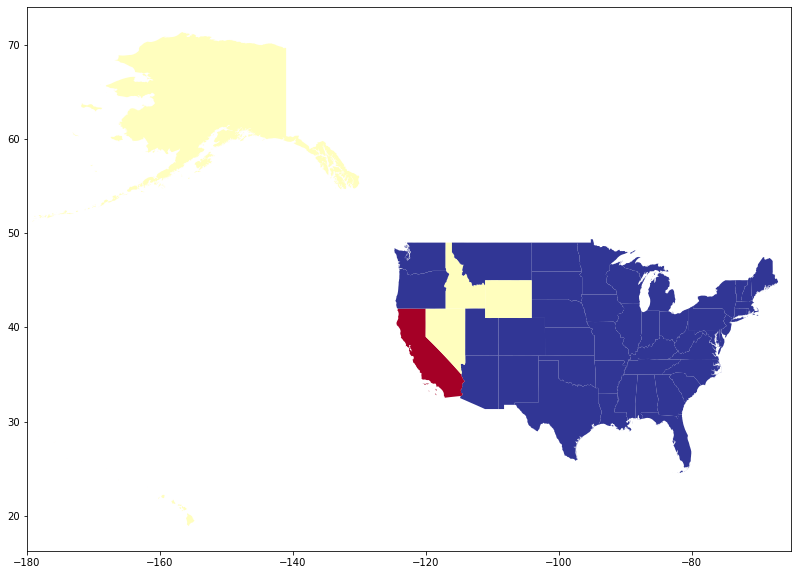

In [30]:
#check the outputs
name = 'efd_cat'
df = df_out_gee[df_out_gee['level'] == 1].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

`Counties`:

(-180.0, -65.0)

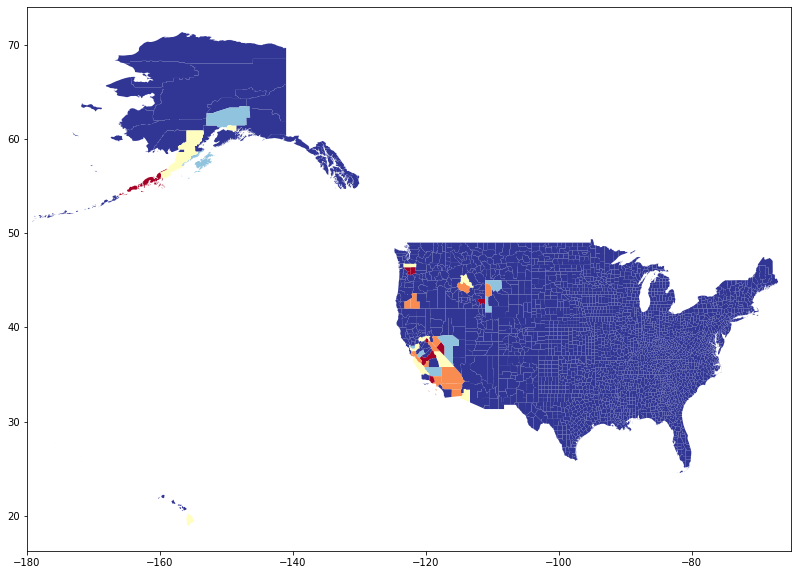

In [31]:
#check the outputs
name = 'efd_cat'
df = df_out_gee[df_out_gee['level'] == 2].copy()

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

<a id='cdc_data'></a>
### 4. [CDC Social Vulnerability Index data](https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html):
CDC SVI Documentation: https://svi.cdc.gov/Documents/Data/2018_SVI_Data/SVI2018Documentation-508.pdf

In [32]:
indicators = {'Name':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
              'household composition & disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian with a disability', 'percentage of single parent households with children under 18',
             'minority status & language', 'minority (all persons except white, non-Hispanic)', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'Slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt'],
 'Category': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'Group': list(range(0, 9)) + [9, 9.1,9.2,9.3,9.4] + [10, 10.1,10.2,10.3,10.4]  + [11, 11.1,11.2] + [12, 12.1,12.2,12.3,12.4,12.5]}

indicators = pd.DataFrame(indicators)
indicators.to_csv('../data/indicators_list.csv')
indicators

,Name,Slug,Category,Group
0,riverine flood risk,rfr,climate risk,0.0
1,coastal flood risk,cfr,climate risk,1.0
2,extreme heat days,ehd,climate risk,2.0
3,extreme precipitation days,epd,climate risk,3.0
4,drought risk,drr,climate risk,4.0
5,landslide susceptibility,lss,climate risk,5.0
6,earthquake frequency and distribution,efd,climate risk,6.0
7,volcano frequency and distribution,vfd,climate risk,7.0
8,wildfires,wlf,climate risk,8.0
9,socioeconomic status,ses,vulnerability,9.0


In [33]:
indicators = {'group': ['climate risk'] * 9 + ['vulnerability'] * 19,
 'indicator':['riverine flood risk', 'coastal flood risk', 'extreme heat days', 'extreme precipitation days',
             'drought risk', 'landslide susceptibility', 'earthquake frequency and distribution',
             'volcano frequency and distribution', 'wildfires'] + 
             ['socioeconomic status', 'percentage of persons below poverty', 'percentage of civilian (age 16+) unemployed', 'per capita income', 'percentage of persons with no high school diploma (age 25+)', 
              'household composition & disability','percentage of persons aged 65 and older', 'percentage of persons aged 17 and younger', 'percentage of civilian with a disability', 'percentage of single parent households with children under 18',
             'minority status & language', 'minority (all persons except white, non-Hispanic)', 'speaks english “less than well”',
             'housing type & transportation', 'multi-unit structures', 'mobile homes', 'crowding', 'no vehicle', 'group quarters'],
 'slug':['rfr', 'cfr', 'ehd', 'epd','drr', 'lss', 'efd','vfd', 'wlf'] + 
        ['ses', 'pov', 'uep', 'pci', 'hsd', 'hcd', 'a6o', 'a1y', 'pcd', 'sph', 'msl', 'mnt', 'sen', 'htt', 'mus', 'mhm', 'cwd', 'vhc', 'gqt']}

indicators = pd.DataFrame(indicators)
indicators

,group,indicator,slug
0,climate risk,riverine flood risk,rfr
1,climate risk,coastal flood risk,cfr
2,climate risk,extreme heat days,ehd
3,climate risk,extreme precipitation days,epd
4,climate risk,drought risk,drr
5,climate risk,landslide susceptibility,lss
6,climate risk,earthquake frequency and distribution,efd
7,climate risk,volcano frequency and distribution,vfd
8,climate risk,wildfires,wlf
9,vulnerability,socioeconomic status,ses


`States`

In [34]:
indicators = ['E_TOTPOP', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP', 'E_AGE65', 'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'E_MINRTY',
 'E_LIMENG', 'E_MUNIT', 'E_MOBILE', 'E_CROWD', 'E_NOVEH', 'E_GROUPQ']

svi_indicator = {
'SPL_THEME1': 'ses',
'EP_POV': 'pov',
'EP_UNEMP': 'uep',
'EP_PCI': 'pci',
'EP_NOHSDP': 'hsd',
'SPL_THEME2': 'hcd',
'EP_AGE65': 'a6o',
'EP_AGE17': 'a1y',
'EP_DISABL': 'pcd',
'EP_SNGPNT': 'sph',
'SPL_THEME3': 'msl',
'EP_MINRTY': 'mnt',
'EP_LIMENG': 'sen',
'SPL_THEME4': 'htt',
'EP_MUNIT': 'mus',
'EP_MOBILE': 'mhm',
'EP_CROWD': 'cwd',
'EP_NOVEH': 'vhc',
'EP_GROUPQ': 'gqt'}

THEME_indicator = {'SPL_THEME1': ['EPL_POV', 'EPL_UNEMP','EPL_PCI', 'EPL_NOHSDP'],
     'SPL_THEME2': ['EPL_AGE65', 'EPL_AGE17', 'EPL_DISABL', 'EPL_SNGPNT'],
     'SPL_THEME3': ['EPL_MINRTY', 'EPL_LIMENG'],
     'SPL_THEME4': ['EPL_MUNIT', 'EPL_MOBILE','EPL_CROWD', 'EPL_NOVEH', 'EPL_GROUPQ']}

In [35]:
svi_state = pd.read_csv('https://svi.cdc.gov/Documents/Data/2018_SVI_Data/CSV/SVI2018_US_COUNTY.csv')
svi_state = svi_state[['ST'] + indicators]
svi_state = svi_state.sort_values('ST')
svi_state = svi_state.replace(-999, np.nan)
svi_state.head()

,ST,E_TOTPOP,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,E_AGE17,E_DISABL,E_SNGPNT,E_MINRTY,E_LIMENG,E_MUNIT,E_MOBILE,E_CROWD,E_NOVEH,E_GROUPQ
2130,1,22527,2863.0,658.0,20199.0,2650,3661,4659,3412,407,5726,57,222,2615,52,410,2091
1329,1,206213,34058.0,6257.0,26064.0,14748,25685,43176,24594,7725,78446,1827,14413,8858,1183,4166,10271
2961,1,12985,3792.0,580.0,15882.0,1238,2198,2522,2797,462,9784,47,392,2094,65,667,897
2960,1,19054,4302.0,1006.0,20125.0,2215,3542,3411,3253,799,16082,0,256,1950,99,989,2301
2959,1,40029,12247.0,1906.0,18910.0,5135,6705,9780,7061,2253,29005,42,299,4161,507,2205,596


In [36]:
indicators.remove('E_PCI')
e_svi_state = svi_state[['ST']+['E_PCI']].groupby('ST').mean().reset_index()
ep_svi_state =  svi_state[['ST']+ indicators].groupby('ST').sum().reset_index()

colm = 'E_PCI'
e_svi_state[colm.replace('E_', 'EP_')] = e_svi_state[colm]
e_svi_state.drop(columns=colm, inplace=True)

indicators.remove('E_TOTPOP')
for colm in indicators:
    ep_svi_state[colm.replace('E_', 'EP_')] = ep_svi_state[colm]/ep_svi_state['E_TOTPOP']*100
    ep_svi_state.drop(columns=colm, inplace=True)
ep_svi_state.drop(columns='E_TOTPOP', inplace=True)

svi_state = pd.merge(e_svi_state, ep_svi_state, on='ST', how='left')
svi_state.head()

,ST,EP_PCI,EP_POV,EP_UNEMP,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_MINRTY,EP_LIMENG,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ
0,1,23072.835821,17.049426,3.040241,9.662362,16.112715,22.587159,16.046646,3.528865,34.286942,0.997332,3.323384,6.130023,0.658584,2.371379,2.442072
1,2,32531.206897,10.543441,3.800459,4.706736,10.619675,25.204329,11.630757,3.289434,38.964897,1.587102,3.188015,2.011466,2.281196,3.244209,3.710008
2,4,23459.400000,15.722492,3.026105,8.824382,16.674428,23.518887,12.741243,3.363460,44.925011,4.555957,4.970745,4.478165,1.627568,2.303415,2.245747
3,5,22442.733333,17.064298,2.533679,9.229668,16.301893,23.604837,16.915903,3.750596,27.312332,1.491070,2.914396,5.589247,1.029702,2.461621,2.815823
4,6,32089.620690,14.016130,3.375591,11.432201,13.577587,23.177375,10.446525,2.956288,62.461554,9.189162,6.177555,1.328936,2.720469,2.398630,2.093244


In [37]:
def compute_percentile(df, columns):
    df = df.copy()
    q = [0,0.2,0.4,0.6,0.8,1]
    scores = [0,0.2,0.4,0.6,0.8,1]
    for column in columns:
        df.sort_values(column, inplace=True)
        
        s = df[column]
        f, quantiles =quantile_interp_function(s,q,scores)

        # Add percentile
        df[column.replace('EP',  'EPL')] = df[column].apply(f)                                                      
        
    return df

In [38]:
svi_state = compute_percentile(svi_state, [colm.replace('E_', 'EP_') for colm in ['E_PCI'] + indicators])
svi_state.head()

quantiles used for aggregate total: 0.0    20906.963415
0.2    24047.347826
0.4    26895.514286
0.6    29278.846154
0.8    32531.206897
1.0    53321.000000
Name: EP_PCI, dtype: float64
quantiles used for aggregate total: 0.0     7.617619
0.2    10.620442
0.4    12.135461
0.6    13.847499
0.8    15.612688
1.0    20.068343
Name: EP_POV, dtype: float64
quantiles used for aggregate total: 0.0    1.553973
0.2    2.235923
0.4    2.664518
0.6    3.016423
0.8    3.213172
1.0    4.291174
Name: EP_UNEMP, dtype: float64
quantiles used for aggregate total: 0.0     4.666075
0.2     5.488965
0.4     6.652228
0.6     7.523201
0.8     9.229668
1.0    11.432201
Name: EP_NOHSDP, dtype: float64
quantiles used for aggregate total: 0.0    10.516657
0.2    14.621809
0.4    15.050214
0.6    16.112715
0.8    16.721106
1.0    19.731763
Name: EP_AGE65, dtype: float64
quantiles used for aggregate total: 0.0    17.784858
0.2    21.110905
0.4    22.385519
0.6    23.075978
0.8    23.768552
1.0    30.178764
Name: EP

,ST,EP_PCI,EP_POV,EP_UNEMP,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_MINRTY,...,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,EPL_MINRTY,EPL_LIMENG,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ
28,32,29034.176471,13.460531,3.481124,9.379992,14.987124,23.075978,12.607357,3.626393,50.113981,...,0.600000,0.486341,0.806884,0.835334,0.862334,0.773643,0.420657,0.831910,0.624933,0.000000
44,49,25467.793103,10.176302,1.936001,4.707505,10.516657,30.178764,9.552498,2.290311,21.380531,...,1.000000,0.000000,0.033153,0.316309,0.558611,0.400000,0.182109,0.720764,0.000000,0.055410
12,16,24397.136364,13.560895,2.232006,6.084278,15.037306,26.020480,13.168848,2.859091,17.783707,...,0.870261,0.578695,0.157820,0.200000,0.496033,0.069523,0.593965,0.637673,0.036062,0.111642
47,53,29278.846154,11.263822,2.718959,6.096799,14.716884,22.385519,12.549696,2.988003,30.916152,...,0.400000,0.476857,0.186076,0.534664,0.724543,0.803686,0.480635,0.800000,0.542679,0.151602
31,35,23747.687500,19.082370,3.213435,9.823870,16.321423,23.616707,14.880517,3.802748,62.325789,...,0.756150,0.820057,0.865678,0.907753,0.800000,0.152691,1.000000,0.805991,0.225886,0.174100


In [39]:
for theme in THEME_indicator.keys():
    svi_state[theme] = svi_state[THEME_indicator[theme]].sum(axis=1)

svi_state.drop(columns=[colm.replace('E_', 'EPL_') for colm in ['E_PCI'] + indicators], inplace=True)

svi_state = svi_state.rename(columns=svi_indicator)
svi_state = svi_state.rename(columns={'ST': 'geoid'})
svi_state.columns = map(str.lower, svi_state.columns)
# add level
svi_state['level'] = 1
# add name
svi_state = pd.merge(state[['geoid', 'name']].astype({'geoid': int}), svi_state, on='geoid', how='left')
svi_state.sort_values('geoid', inplace=True)
svi_state = svi_state[['geoid', 'name', 'level'] + list(svi_indicator.values())]
svi_state.head()

,geoid,name,level,ses,pov,uep,pci,hsd,hcd,a6o,...,sph,msl,mnt,sen,htt,mus,mhm,cwd,vhc,gqt
0,1,Alabama,1,2.465929,17.049426,3.040241,23072.835821,9.662362,2.661856,16.112715,...,3.528865,0.812682,34.286942,0.997332,2.033338,3.323384,6.130023,0.658584,2.371379,2.442072
1,2,Alaska,1,1.913712,10.543441,3.800459,32531.206897,4.706736,1.601144,10.619675,...,3.289434,1.108321,38.964897,1.587102,3.137083,3.188015,2.011466,2.281196,3.244209,3.710008
2,4,Arizona,1,2.329827,15.722492,3.026105,23459.400000,8.824382,2.612777,16.674428,...,3.363460,1.621706,44.925011,4.555957,2.733684,4.970745,4.478165,1.627568,2.303415,2.245747
3,5,Arkansas,1,2.101911,17.064298,2.533679,22442.733333,9.229668,3.167306,16.301893,...,3.750596,0.850120,27.312332,1.491070,2.719833,2.914396,5.589247,1.029702,2.461621,2.815823
4,6,California,1,3.222085,14.016130,3.375591,32089.620690,11.432201,1.059468,13.577587,...,2.956288,1.908558,62.461554,9.189162,2.552118,6.177555,1.328936,2.720469,2.398630,2.093244


`County`

In [40]:
svi_indicator = {
'SPL_THEME1': 'ses',
'EP_POV': 'pov',
'EP_UNEMP': 'uep',
'E_PCI': 'pci',
'EP_NOHSDP': 'hsd',
'SPL_THEME2': 'hcd',
'EP_AGE65': 'a6o',
'EP_AGE17': 'a1y',
'EP_DISABL': 'pcd',
'EP_SNGPNT': 'sph',
'SPL_THEME3': 'msl',
'EP_MINRTY': 'mnt',
'EP_LIMENG': 'sen',
'SPL_THEME4': 'htt',
'EP_MUNIT': 'mus',
'EP_MOBILE': 'mhm',
'EP_CROWD': 'cwd',
'EP_NOVEH': 'vhc',
'EP_GROUPQ': 'gqt'}

In [41]:
svi_county = pd.read_csv('https://svi.cdc.gov/Documents/Data/2018_SVI_Data/CSV/SVI2018_US_COUNTY.csv')
svi_county = svi_county[['ST','FIPS']+list(svi_indicator.keys())]
svi_county = svi_county.rename(columns=svi_indicator)
svi_county = svi_county.rename(columns={'FIPS': 'geoid'})
svi_county.columns = map(str.lower, svi_county.columns)
svi_county = svi_county.replace(-999, np.nan)
svi_county['level'] = 2
# add name
svi_county = pd.merge(county[['geoid', 'name']].astype({'geoid': int}), svi_county, on='geoid', how='left')
svi_county.sort_values('geoid', inplace=True)
svi_county = svi_county[['geoid', 'name', 'level'] + list(svi_indicator.values())]
svi_county.head()

,geoid,name,level,ses,pov,uep,pci,hsd,hcd,a6o,...,sph,msl,mnt,sen,htt,mus,mhm,cwd,vhc,gqt
0,1001,Autauga,2,1.5403,15.4,4.2,29372.0,11.3,2.1076,14.6,...,7.5,1.1449,25.0,0.8,2.2760,3.8,18.4,1.4,5.6,1.0
1,1003,Baldwin,2,1.0626,10.6,4.4,31203.0,9.7,1.5666,19.5,...,5.7,0.8740,17.0,0.5,2.2002,18.3,11.7,1.3,3.4,1.4
2,1005,Barbour,2,3.8030,28.9,9.5,18461.0,27.0,2.6752,18.0,...,12.8,1.6017,53.9,1.6,3.8028,1.3,29.2,3.4,9.2,11.2
3,1007,Bibb,2,2.8663,14.0,7.5,20199.0,16.8,1.3826,16.3,...,6.0,0.8660,25.4,0.3,2.9160,2.4,28.5,0.8,6.0,9.3
4,1009,Blount,2,2.3300,14.4,4.1,22656.0,19.8,1.7845,17.8,...,7.0,1.1376,12.9,1.7,1.7616,0.9,25.2,1.6,4.2,0.9


`Census tract`

In [42]:
svi_tract = pd.read_csv('https://svi.cdc.gov/Documents/Data/2018_SVI_Data/CSV/SVI2018_US.csv')
svi_tract = svi_tract[['ST','FIPS']+list(svi_indicator.keys())]
svi_tract = svi_tract.rename(columns=svi_indicator)
svi_tract = svi_tract.rename(columns={'FIPS': 'geoid'})
svi_tract.columns = map(str.lower, svi_tract.columns)
svi_tract = svi_tract.replace(-999, np.nan)
svi_tract['level'] = 3
# add name
svi_tract = pd.merge(tract[['geoid', 'name']].astype({'geoid': int}), svi_tract, on='geoid', how='left')
svi_tract = svi_tract[['geoid', 'name', 'level'] + list(svi_indicator.values())]
svi_tract.sort_values('geoid', inplace=True)
svi_tract.head()

,geoid,name,level,ses,pov,uep,pci,hsd,hcd,a6o,...,sph,msl,mnt,sen,htt,mus,mhm,cwd,vhc,gqt
0,1001020100,201,3,1.6107,11.3,3.6,31580.0,9.4,2.1038,12.7,...,8.6,0.7606,19.9,0.8,1.1418,0.0,17.3,0.4,0.8,0.0
1,1001020200,202,3,2.6398,17.9,4.5,19376.0,17.0,1.8082,14.0,...,4.7,1.1113,60.1,0.7,2.8445,0.5,1.5,0.8,12.4,10.0
2,1001020300,203,3,2.1657,15.0,3.3,22527.0,12.8,2.6595,16.7,...,8.3,1.2223,33.7,3.3,2.0682,1.3,1.4,2.2,7.6,0.0
3,1001020400,204,3,0.9594,2.8,2.9,30527.0,6.0,2.4903,23.5,...,6.3,0.7470,12.3,1.4,0.8862,3.9,0.0,0.8,1.3,0.0
4,1001020500,205,3,1.2653,15.2,2.1,40235.0,7.1,2.2336,13.8,...,6.9,0.8385,23.8,0.9,2.6824,16.0,0.4,0.5,5.5,1.8


In [43]:
df_svi = pd.concat([svi_state, svi_county, svi_tract])
df_svi

,geoid,name,level,ses,pov,uep,pci,hsd,hcd,a6o,...,sph,msl,mnt,sen,htt,mus,mhm,cwd,vhc,gqt
0,1,Alabama,1,2.465929,17.049426,3.040241,23072.835821,9.662362,2.661856,16.112715,...,3.528865,0.812682,34.286942,0.997332,2.033338,3.323384,6.130023,0.658584,2.371379,2.442072
1,2,Alaska,1,1.913712,10.543441,3.800459,32531.206897,4.706736,1.601144,10.619675,...,3.289434,1.108321,38.964897,1.587102,3.137083,3.188015,2.011466,2.281196,3.244209,3.710008
2,4,Arizona,1,2.329827,15.722492,3.026105,23459.400000,8.824382,2.612777,16.674428,...,3.363460,1.621706,44.925011,4.555957,2.733684,4.970745,4.478165,1.627568,2.303415,2.245747
3,5,Arkansas,1,2.101911,17.064298,2.533679,22442.733333,9.229668,3.167306,16.301893,...,3.750596,0.850120,27.312332,1.491070,2.719833,2.914396,5.589247,1.029702,2.461621,2.815823
4,6,California,1,3.222085,14.016130,3.375591,32089.620690,11.432201,1.059468,13.577587,...,2.956288,1.908558,62.461554,9.189162,2.552118,6.177555,1.328936,2.720469,2.398630,2.093244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72826,56043000200,2,3,1.831400,9.700000,5.600000,30953.000000,9.600000,2.303300,21.400000,...,6.600000,0.238200,11.900000,0.000000,3.068100,1.000000,22.100000,2.800000,4.600000,2.100000
72827,56043000301,3.01,3,1.978800,11.600000,3.700000,24938.000000,12.000000,2.462100,17.200000,...,9.600000,0.726900,25.600000,0.400000,2.537000,0.000000,6.200000,1.500000,8.000000,1.400000
72828,56043000302,3.02,3,2.576800,16.300000,9.900000,25961.000000,10.100000,2.555800,23.400000,...,4.700000,0.710200,18.100000,0.700000,2.412700,2.500000,4.300000,0.700000,2.300000,2.600000
72829,56045951100,9511,3,1.614200,17.500000,1.200000,29414.000000,8.800000,2.216900,20.500000,...,7.200000,0.503700,11.300000,0.400000,3.201100,1.300000,21.800000,3.600000,3.300000,8.700000


In [44]:
q = [0,0.2,0.4,0.6,0.8,1]
scores = [0,1,2,3,4,5]

for n in df_svi['level'].unique():
    df_tmp  = compute_score_category_label(df_svi[df_svi['level'] == n], columns=list(svi_indicator.values()), q=q, scores=scores)

    if n == 1:
        df_out_svi = df_tmp
    else:
        df_out_svi = pd.concat([df_out_svi, df_tmp])

df_out_svi

quantiles used for aggregate total: 0.0    0.592272
0.2    1.292582
0.4    1.985043
0.6    2.266771
0.8    2.427727
1.0    3.226315
Name: ses, dtype: float64
quantiles used for aggregate total: 0.0     7.617619
0.2    10.620442
0.4    12.135461
0.6    13.847499
0.8    15.612688
1.0    20.068343
Name: pov, dtype: float64
quantiles used for aggregate total: 0.0    1.553973
0.2    2.235923
0.4    2.664518
0.6    3.016423
0.8    3.213172
1.0    4.291174
Name: uep, dtype: float64
quantiles used for aggregate total: 0.0    20906.963415
0.2    24047.347826
0.4    26895.514286
0.6    29278.846154
0.8    32531.206897
1.0    53321.000000
Name: pci, dtype: float64
quantiles used for aggregate total: 0.0     4.666075
0.2     5.488965
0.4     6.652228
0.6     7.523201
0.8     9.229668
1.0    11.432201
Name: hsd, dtype: float64
quantiles used for aggregate total: 0.0    0.928796
0.2    1.307318
0.4    1.948821
0.6    2.186990
0.8    2.612777
1.0    3.167306
Name: hcd, dtype: float64
quantiles used f

<ipython-input-4-9d29ab5693b9>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp1[f"{column}_range"] = 'Data not available'
<ipython-input-4-9d29ab5693b9>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp2[f"{column}_range"] = df_tmp2[f"{column}_cat"].apply(lambda x: str([quantiles[x],quantiles[x+1]]))
<ipython-input-4-9d29ab5693b9>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

quantiles used for aggregate total: 0.0     2.3
0.2    10.1
0.4    13.3
0.6    16.2
0.8    20.2
1.0    55.1
Name: pov, dtype: float64
quantiles used for aggregate total: 0.0     0.2
0.2     3.6
0.4     4.9
0.6     6.0
0.8     7.6
1.0    28.9
Name: uep, dtype: float64
quantiles used for aggregate total: 0.0    10148.0
0.2    22018.0
0.4    24825.0
0.6    27609.0
0.8    31324.0
1.0    72832.0
Name: pci, dtype: float64
quantiles used for aggregate total: 0.0     1.20
0.2     8.00
0.4    10.70
0.6    13.90
0.8    18.68
1.0    66.30
Name: hsd, dtype: float64
quantiles used for aggregate total: 0.0    0.13720
0.2    1.57192
0.4    1.89098
0.6    2.13164
0.8    2.40782
1.0    3.62840
Name: hcd, dtype: float64
quantiles used for aggregate total: 0.0     3.8
0.2    14.8
0.4    17.1
0.6    19.1
0.8    21.5
1.0    55.6
Name: a6o, dtype: float64
quantiles used for aggregate total: 0.0     5.3
0.2    19.8
0.4    21.7
0.6    23.0
0.8    24.6
1.0    40.5
Name: a1y, dtype: float64
quantiles used for a

,geoid,name,level,ses,pov,uep,pci,hsd,hcd,a6o,...,mhm_range,cwd_score,cwd_cat,cwd_range,vhc_score,vhc_cat,vhc_range,gqt_score,gqt_cat,gqt_range
28,32,Nevada,1,2.797626,13.460531,3.481124,29034.176471,9.379992,2.263771,14.987124,...,"[2.096535614860339, 3.5584903503185985]",4.159551,4,"[1.257304297471353, 2.9097156246461924]",3.124666,3,"[2.7367292711435045, 3.269011824064057]",0.000000,0,"[1.2898374154805807, 2.1665511690987445]"
44,49,Utah,1,0.592272,10.176302,1.936001,25467.793103,4.707505,1.033153,10.516657,...,"[0.033601266913855114, 1.3289360889080524]",3.603818,3,"[0.8927565652292759, 1.257304297471353]",0.000000,0,"[1.2966654079169881, 2.11938032520563]",0.277049,0,"[1.2898374154805807, 2.1665511690987445]"
12,16,Idaho,1,1.292285,13.560895,2.232006,24397.136364,6.084278,2.000750,15.037306,...,"[2.096535614860339, 3.5584903503185985]",3.188363,3,"[0.8927565652292759, 1.257304297471353]",0.180310,0,"[1.2966654079169881, 2.11938032520563]",0.558212,0,"[1.2898374154805807, 2.1665511690987445]"
47,53,Washington,1,1.620379,11.263822,2.718959,29278.846154,6.096799,1.307318,14.716884,...,"[2.096535614860339, 3.5584903503185985]",4.000000,4,"[1.257304297471353, 2.9097156246461924]",2.713395,2,"[2.379833753565434, 2.7367292711435045]",0.758008,0,"[1.2898374154805807, 2.1665511690987445]"
31,35,New Mexico,1,2.790664,19.082370,3.213435,23747.687500,9.823870,3.110495,16.321423,...,"[5.311826842220456, 7.5589480958539195]",4.029956,4,"[1.257304297471353, 2.9097156246461924]",1.129429,1,"[2.11938032520563, 2.379833753565434]",0.870499,0,"[1.2898374154805807, 2.1665511690987445]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33163,26065004492,44.92,3,NaN,NaN,21.700000,5163.000000,0.000000,0.014600,0.000000,...,Data not available,0.000000,0,"[0.1, 1.0]",NaN,-1,Data not available,5.000000,4,"[3.8, 100.0]"
59506,45079010408,104.08,3,3.839800,94.100000,10.700000,3311.000000,41.200000,1.033500,2.800000,...,Data not available,0.000000,0,"[0.1, 1.0]",NaN,-1,Data not available,5.000000,4,"[3.8, 100.0]"
40212,32031980000,9800,3,NaN,NaN,NaN,1434.000000,0.000000,NaN,8.600000,...,Data not available,0.000000,0,"[0.1, 1.0]",NaN,-1,Data not available,5.000000,4,"[3.8, 100.0]"
2871,4027980005,9800.05,3,NaN,NaN,NaN,2935.000000,76.500000,NaN,0.000000,...,Data not available,0.000000,0,"[0.1, 1.0]",NaN,-1,Data not available,5.000000,4,"[3.8, 100.0]"


In [ ]:
df_out_svi.sort_values(['level', 'geoid'], inplace=True)
df_out_svi.to_csv('../data/svi_indicators.csv')

**Check the outputs**

`States`:

(-180.0, -65.0)

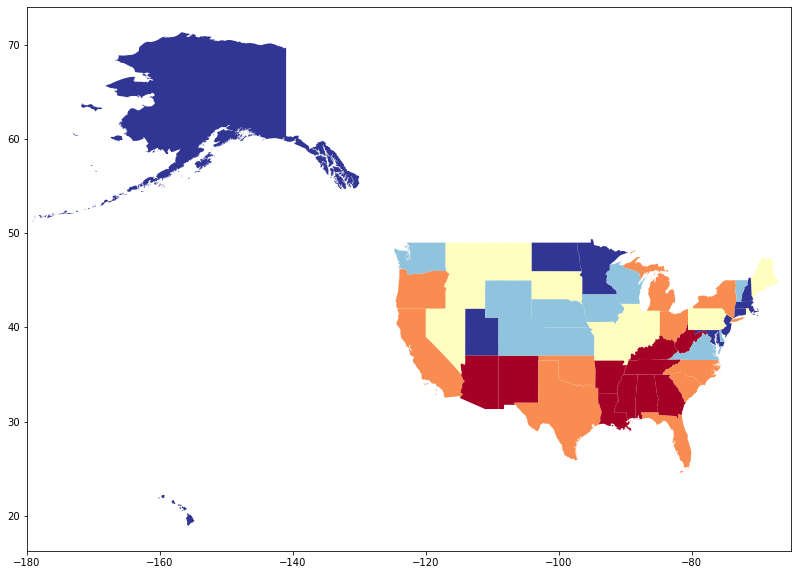

In [45]:
#check the outputs
name = 'pov_cat'
df = df_out_svi[df_out_svi['level'] == 1].copy()
df = gpd.GeoDataFrame(pd.merge(df, state[['geoid', 'geometry']].astype({'geoid': int}), on='geoid', how='left'))
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)  

`Counties`:

(-180.0, -65.0)

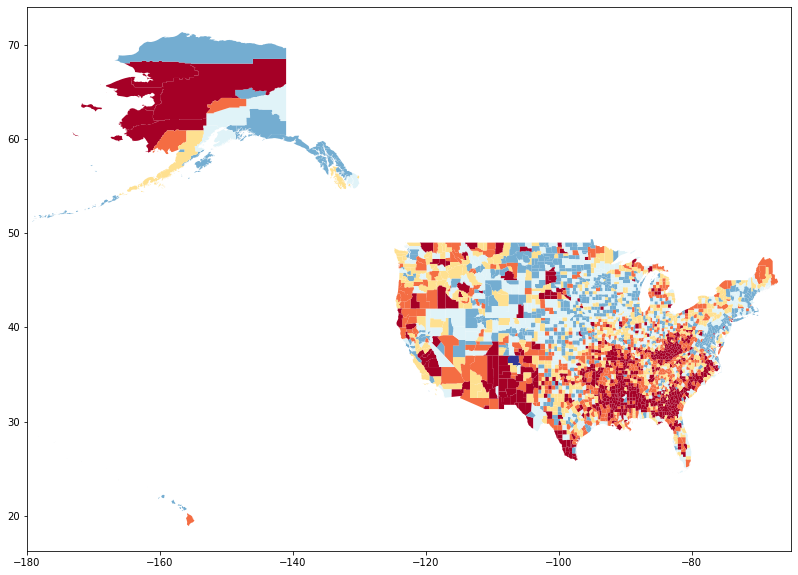

In [46]:
#check the outputs
name = 'pov_cat'
df = df_out_svi[df_out_svi['level'] == 2].copy()
df = gpd.GeoDataFrame(pd.merge(df, county[['geoid', 'geometry']].astype({'geoid': int}), on='geoid', how='left'))
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65)  

`Census tracts`:

(-180.0, -65.0)

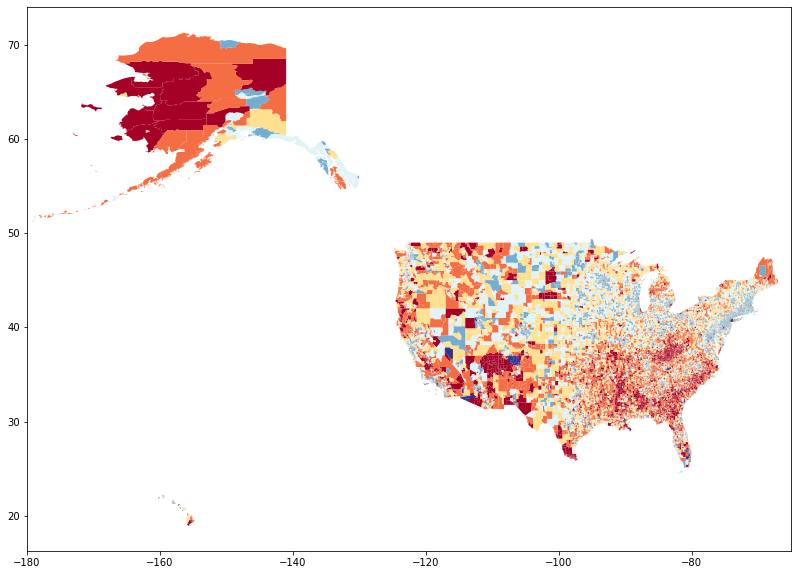

In [47]:
#check the outputs
name = 'pov_cat'
df = df_out_svi[df_out_svi['level'] == 3].copy()
df = gpd.GeoDataFrame(pd.merge(df, tract[['geoid', 'geometry']].astype({'geoid': int}), on='geoid', how='left'))
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap='RdYlBu_r')
plt.xlim(-180, -65) 

<a id='merge_data'></a>
## Merge all datasets

In [ ]:
svi_indicator = {
'SPL_THEME1': 'ses',
'EP_POV': 'pov',
'EP_UNEMP': 'uep',
'EP_PCI': 'pci',
'EP_NOHSDP': 'hsd',
'SPL_THEME2': 'hcd',
'EP_AGE65': 'a6o',
'EP_AGE17': 'a1y',
'EP_DISABL': 'pcd',
'EP_SNGPNT': 'sph',
'SPL_THEME3': 'msl',
'EP_MINRTY': 'mnt',
'EP_LIMENG': 'sen',
'SPL_THEME4': 'htt',
'EP_MUNIT': 'mus',
'EP_MOBILE': 'mhm',
'EP_CROWD': 'cwd',
'EP_NOVEH': 'vhc',
'EP_GROUPQ': 'gqt'}

indicartos = ['rfr', 'cfr', 'ehd', 'epd', 'drr', 'lss', 'efd','vfd', 'wlf']+list(svi_indicator.values())

In [ ]:
df_carto = pd.read_csv('../data/carto_indicators.csv').drop(columns=['Unnamed: 0', 'statefp', 'countyfp', 'tractce', 'bbox', 'geometry'])
df_gee = pd.read_csv('../data/gee_indicators.csv').drop(columns=['Unnamed: 0', 'index', 'statefp', 'countyfp', 'bbox', 'geometry'])
df_wlf = pd.read_csv('../data/wlf_indicators.csv').drop(columns=['Unnamed: 0', 'statefp', 'countyfp', 'bbox', 'geometry'])
df_svi = pd.read_csv('../data/svi_indicators.csv').drop(columns='Unnamed: 0')

In [ ]:
#df_all = pd.merge(df_svi, df_carto, on=['geoid', 'level', 'name'], how='left')
#df_all = pd.merge(df_all, df_gee, on=['geoid', 'level', 'name'], how='left')
#df_all = pd.merge(df_all, df_wlf, on=['geoid', 'level', 'name'], how='left')
df_all = pd.merge(df_svi, df_carto, on=['geoid', 'level'], how='left')
df_all = pd.merge(df_all, df_gee, on=['geoid', 'level'], how='left')
df_all = pd.merge(df_all, df_wlf, on=['geoid', 'level'], how='left')
df_all.drop(columns='name_y', inplace=True)
df_all.rename(columns={'name_x': 'name'}, inplace=True)

In [ ]:
df_all

In [ ]:
all_indicators = []
for indicator in indicartos:
    all_indicators.append([indicator, f'{indicator}_score', f'{indicator}_cat', f'{indicator}_range'])
all_indicators = [item for sublist in all_indicators for item in sublist]

In [ ]:
df_all = df_all[['geoid', 'name', 'level']+all_indicators]

In [ ]:
state['geoid_int'] = state['geoid']
county['geoid_int'] = county['geoid']
tract['geoid_int'] = tract['geoid']

df_all = pd.concat([pd.merge(state[['geoid', 'geoid_int']].astype({'geoid_int':int}), df_all[df_all['level'] == 1], left_on='geoid_int', right_on='geoid', how='left')\
                    .drop(columns=['geoid_int', 'geoid_y']).rename(columns={'geoid_x': 'geoid'}),
    pd.merge(county[['geoid', 'geoid_int']].astype({'geoid_int':int}), df_all[df_all['level'] == 2], left_on='geoid_int', right_on='geoid', how='left')\
                    .drop(columns=['geoid_int', 'geoid_y']).rename(columns={'geoid_x': 'geoid'}),
    pd.merge(tract[['geoid', 'geoid_int']].astype({'geoid_int':int}), df_all[df_all['level'] == 3], left_on='geoid_int', right_on='geoid', how='left')\
                    .drop(columns=['geoid_int', 'geoid_y']).rename(columns={'geoid_x': 'geoid'})])

In [ ]:
df_all

Save as `csv`

In [ ]:
df_all.to_csv("../data/indicators.csv")

In [ ]:
df = pd.read_csv("../data/indicators.csv")

In [ ]:
df

In [ ]:
df = pd.read_csv("../data/indicators.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df = df[df['level'] == 3]
df = pd.merge(df,tract.astype({'geoid': int}), how='left', on='geoid')
df = gpd.GeoDataFrame(df)
df.head()

In [ ]:
#check the outputs
name = 'rfr_score'

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(name, ax=ax, cmap="RdYlBu_r")
plt.xlim(-180, -65)

In [ ]:
indicators